# Skincancer HAM-dataset using Pytorch

### Standardimporter

In [205]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader, Dataset
from torchvision import datasets, transforms
from torchvision.utils import make_grid
import os
from PIL import Image
from skimage import io, transform

import numpy as np
import pandas as pd
#from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
%matplotlib inline

In [206]:
import locale
locale.setlocale(locale.LC_ALL, '')

'LC_CTYPE=en_US.UTF-8;LC_NUMERIC=sv_SE.UTF-8;LC_TIME=sv_SE.UTF-8;LC_COLLATE=en_US.UTF-8;LC_MONETARY=sv_SE.UTF-8;LC_MESSAGES=en_US.UTF-8;LC_PAPER=sv_SE.UTF-8;LC_NAME=sv_SE.UTF-8;LC_ADDRESS=sv_SE.UTF-8;LC_TELEPHONE=sv_SE.UTF-8;LC_MEASUREMENT=sv_SE.UTF-8;LC_IDENTIFICATION=sv_SE.UTF-8'

In [296]:
homePath = os.path.dirname("/home/johan/Dropbox/coding/")
# print(homePath) ---> /home/johan/Dropbox/coding

basePath = homePath + "/" +"ml/Datasets/skin-cancer-mnist-ham10000/images_in_one"
# print(basePath) ---> /home/johan/Dropbox/coding/ml/Datasets/skin-cancer-mnist-ham10000/

imageFolder = "images_per_label_splitted_sets"

metadataSkincancerFilename =  "../../../ml/Datasets/skin-cancer-mnist-ham10000/csv/HAM10000_metadata.csv"

In [297]:
print(metadataSkincancerFilename)

../../../ml/Datasets/skin-cancer-mnist-ham10000/csv/HAM10000_metadata.csv


In [298]:
# Importera metadatan i en Pandas DataFrame:

skincancer_df = pd.read_csv(metadataSkincancerFilename)

In [299]:
# Kolla om vi har några noll-värden i vår Dataframe:

skincancer_df.isnull().sum()

lesion_id        0
image_id         0
dx               0
dx_type          0
age             57
sex              0
localization     0
dtype: int64

In [300]:
# Enligt ovan är det bara i "age"-kolumnen som vi har noll-värden. 
# Dessa fyller vi ut genom att beräkna medevärdet:

skincancer_df['age'].fillna((skincancer_df['age'].mean()), inplace=True)

In [301]:
labels = skincancer_df['dx']
num_classes = len(labels.unique()) # --> 7

In [302]:
np_labels = np.array(labels)

In [303]:
from sklearn.preprocessing import LabelEncoder
label_encoder = LabelEncoder()

enc_labels = label_encoder.fit_transform(np_labels)
enc_labels

array([2, 2, 2, ..., 0, 0, 4])

In [304]:
torch_labels = torch.from_numpy(enc_labels)
torch_labels

tensor([2, 2, 2,  ..., 0, 0, 4])

In [305]:
# Innan vi fortsätter måste vi göra om 
# text-datan till numeriska features.

# 1. Flytta labels sist i df
# 2. Flytta age till efter image_id
# 3. Alla categorical features emellan.

skincancer_df = skincancer_df[['lesion_id', 'image_id', 'age', 'dx_type', 'sex', 'localization', 'dx']]
skincancer_df.head(n = 3)

,lesion_id,image_id,age,dx_type,sex,localization,dx
0,HAM_0000118,ISIC_0027419,80.0,histo,male,scalp,bkl
1,HAM_0000118,ISIC_0025030,80.0,histo,male,scalp,bkl
2,HAM_0002730,ISIC_0026769,80.0,histo,male,scalp,bkl


In [306]:
from sklearn.preprocessing import LabelEncoder

In [307]:
dxtype_feat_df = skincancer_df.iloc[:, 3]
dxtype_feat_df.value_counts()

histo        5340
follow_up    3704
consensus     902
confocal       69
Name: dx_type, dtype: int64

In [308]:
sex_feat_df = skincancer_df.iloc[:, 4]
sex_feat_df.value_counts()

male       5406
female     4552
unknown      57
Name: sex, dtype: int64

In [309]:
loc_feat_df = skincancer_df.iloc[:, 3]
loc_feat_df.value_counts()

histo        5340
follow_up    3704
consensus     902
confocal       69
Name: dx_type, dtype: int64

In [310]:
label_df = skincancer_df.iloc[:, 6]
label_df.value_counts()

nv       6705
mel      1113
bkl      1099
bcc       514
akiec     327
vasc      142
df        115
Name: dx, dtype: int64

(array([  69.,    0.,    0.,  902.,    0.,    0., 3704.,    0.,    0.,
        5340.]),
 array([0. , 0.3, 0.6, 0.9, 1.2, 1.5, 1.8, 2.1, 2.4, 2.7, 3. ]),
 <a list of 10 Patch objects>)

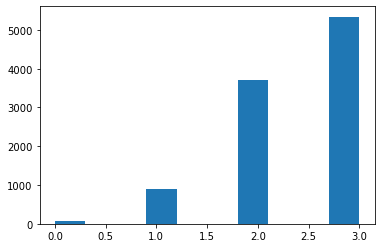

In [311]:
le = LabelEncoder()
dxtype_feat = le.fit_transform(dxtype_feat_df)
plt.hist(dxtype_feat)

(array([  69.,    0.,    0.,  902.,    0.,    0., 3704.,    0.,    0.,
        5340.]),
 array([0. , 0.3, 0.6, 0.9, 1.2, 1.5, 1.8, 2.1, 2.4, 2.7, 3. ]),
 <a list of 10 Patch objects>)

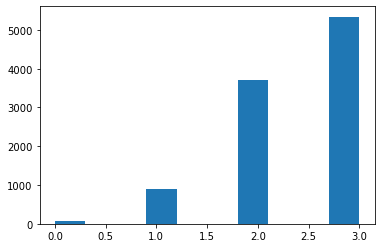

In [312]:
le = LabelEncoder()
loc_feat = le.fit_transform(loc_feat_df)
plt.hist(loc_feat)

(array([4552.,    0.,    0.,    0.,    0., 5406.,    0.,    0.,    0.,
          57.]),
 array([0. , 0.2, 0.4, 0.6, 0.8, 1. , 1.2, 1.4, 1.6, 1.8, 2. ]),
 <a list of 10 Patch objects>)

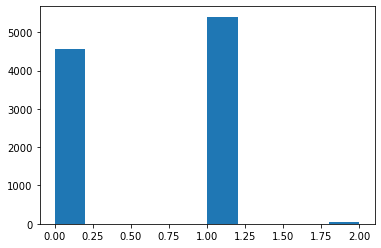

In [313]:
le = LabelEncoder()
sex_feat = le.fit_transform(sex_feat_df)
plt.hist(sex_feat)

(array([ 327.,  514.,    0., 1099.,    0.,  115., 1113.,    0., 6705.,
         142.]),
 array([0. , 0.6, 1.2, 1.8, 2.4, 3. , 3.6, 4.2, 4.8, 5.4, 6. ]),
 <a list of 10 Patch objects>)

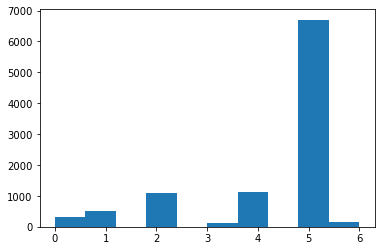

In [314]:
le = LabelEncoder()
labels = le.fit_transform(label_df)
plt.hist(labels)

In [315]:
skincancer_df.head()

,lesion_id,image_id,age,dx_type,sex,localization,dx
0,HAM_0000118,ISIC_0027419,80.0,histo,male,scalp,bkl
1,HAM_0000118,ISIC_0025030,80.0,histo,male,scalp,bkl
2,HAM_0002730,ISIC_0026769,80.0,histo,male,scalp,bkl
3,HAM_0002730,ISIC_0025661,80.0,histo,male,scalp,bkl
4,HAM_0001466,ISIC_0031633,75.0,histo,male,ear,bkl


In [316]:
le_skincancer_df = skincancer_df.copy()

In [317]:
le_skincancer_df['dxtype'] = dxtype_feat
le_skincancer_df['sex'] = sex_feat
le_skincancer_df['loc'] = loc_feat
le_skincancer_df['label'] = labels
le_skincancer_df.drop(columns=['localization', 'dx_type', 'dx'], inplace = True)
le_skincancer_df.head()

,lesion_id,image_id,age,sex,dxtype,loc,label
0,HAM_0000118,ISIC_0027419,80.0,1,3,3,2
1,HAM_0000118,ISIC_0025030,80.0,1,3,3,2
2,HAM_0002730,ISIC_0026769,80.0,1,3,3,2
3,HAM_0002730,ISIC_0025661,80.0,1,3,3,2
4,HAM_0001466,ISIC_0031633,75.0,1,3,3,2


In [318]:
# Vi normaliserar metadata-features
# innan vi skickar in det till Pytorch:

from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler()

In [320]:
le_skincancer_df[['age', 'dxtype', 'loc']] = scaler.fit_transform(le_skincancer_df[['age', 'dxtype', 'loc']])

In [321]:
le_skincancer_df.head(n = 5)

,lesion_id,image_id,age,sex,dxtype,loc,label
0,HAM_0000118,ISIC_0027419,0.941176,1,1.0,1.0,2
1,HAM_0000118,ISIC_0025030,0.941176,1,1.0,1.0,2
2,HAM_0002730,ISIC_0026769,0.941176,1,1.0,1.0,2
3,HAM_0002730,ISIC_0025661,0.941176,1,1.0,1.0,2
4,HAM_0001466,ISIC_0031633,0.882353,1,1.0,1.0,2


## Bygg en egen dataloader-klass för bilder och Pandas-dataframe

In [323]:
# Samma klass som ovan, men läser från en 
# Pandas-df istället från en csv:

class SkinCancerHamDF(Dataset):

    def __init__(self, dataframe, root_dir, transform = None):

        self.dataframe = dataframe
        self.root_dir = root_dir
        self.transform = transform

    def __len__(self):
        return len(self.dataframe)

    def __getitem__(self, idx):
        if torch.is_tensor(idx):
            idx = idx.tolist()

        img_name = os.path.join(self.root_dir,
                                self.dataframe.iloc[idx, 1])
        
        img_name = img_name + ".jpg"
        
        # pillow:
        image = Image.open(img_name)
        
        # labels:
        skincancer_label = self.dataframe.iloc[idx, 6:]
        skincancer_label_np = np.array([skincancer_label], dtype = int)
        
        # features:
        skincancer_metadata = self.dataframe.iloc[idx, 2:6]
        skincancer_metadata_np = np.array([skincancer_metadata], dtype = float)
        
        # Skapar en batch utan transforms:
        sample = {'image': image, \
                  'metadata': skincancer_metadata_np, \
                  'label': skincancer_label_np}

        # Skapar en batch med transforms:
        if self.transform:
            sample = {'image': self.transform(image), \
                      'metadata': skincancer_metadata_np, \
                      'label': skincancer_label_np.flatten()}

        return sample

### Testa klassen...

In [329]:
# Definiera en batch-storlek:
batchsz = 2**3

# Definiera vilken augmentation som ska göras:
train_data_transform = transforms.Compose([transforms.RandomResizedCrop(224),\
                                           #transforms.Resize([224, 224]),\
                                           transforms.ToTensor(), \
                                           transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                             std=[0.229, 0.224, 0.225])
                                           ])

In [330]:
ham10k_dataset = SkinCancerHamDF(dataframe = le_skincancer_df, \
                                 root_dir = basePath, \
                                 transform = train_data_transform)

In [331]:
next(iter(ham10k_dataset))

{'image': tensor([[[1.7523, 1.7523, 1.7352,  ..., 1.2899, 1.3070, 1.3584],
          [1.7180, 1.7180, 1.7180,  ..., 1.4098, 1.3413, 1.3413],
          [1.6667, 1.6495, 1.6838,  ..., 1.4612, 1.3927, 1.4098],
          ...,
          [1.6495, 1.6495, 1.6495,  ..., 1.6495, 1.6495, 1.6667],
          [1.6495, 1.6667, 1.6324,  ..., 1.6838, 1.6667, 1.6495],
          [1.6667, 1.6667, 1.6667,  ..., 1.6667, 1.6153, 1.6495]],
 
         [[1.3957, 1.3957, 1.3606,  ..., 0.4503, 0.4153, 0.4853],
          [1.2906, 1.2731, 1.2731,  ..., 0.5553, 0.4853, 0.5203],
          [1.2206, 1.1856, 1.2206,  ..., 0.6429, 0.5903, 0.6078],
          ...,
          [1.2731, 1.2731, 1.2906,  ..., 1.0980, 1.0980, 1.0980],
          [1.2556, 1.2556, 1.3081,  ..., 1.0630, 1.0630, 1.0980],
          [1.2381, 1.2731, 1.3081,  ..., 0.9930, 1.0630, 1.0630]],
 
         [[2.0300, 2.0474, 1.9951,  ..., 0.8099, 0.8448, 0.9319],
          [1.9428, 1.9254, 1.9428,  ..., 1.0888, 0.9668, 1.0539],
          [1.8731, 1.8208, 1.89

In [332]:
#ham10k_generator = DataLoader(ham10k_dataset, **params)

ham10k_generator = DataLoader(ham10k_dataset, \
                              batch_size = batchsz, \
                              pin_memory = True, \
                             )

In [333]:
next(iter(ham10k_generator))

{'image': tensor([[[[ 1.7009,  1.7009,  1.6495,  ...,  1.5468,  1.6153,  1.5810],
           [ 1.6838,  1.6667,  1.6495,  ...,  1.5639,  1.6153,  1.5810],
           [ 1.6667,  1.6495,  1.6667,  ...,  1.5639,  1.5810,  1.5982],
           ...,
           [ 1.3927,  1.3755,  1.3584,  ...,  1.4440,  1.4269,  1.4612],
           [ 1.3927,  1.3242,  1.3413,  ...,  1.4269,  1.4612,  1.4440],
           [ 1.3755,  1.3242,  1.3584,  ...,  1.4612,  1.4783,  1.4612]],
 
          [[ 1.0805,  1.0280,  1.0455,  ...,  0.8354,  0.9230,  0.9755],
           [ 1.0805,  1.0105,  1.0280,  ...,  0.8704,  0.9405,  0.9580],
           [ 1.0455,  1.0105,  0.9930,  ...,  0.8179,  0.9055,  0.9405],
           ...,
           [ 0.5903,  0.5728,  0.5553,  ...,  0.9230,  0.9580,  0.9755],
           [ 0.6078,  0.5378,  0.5203,  ...,  0.9230,  0.9230,  0.9580],
           [ 0.5903,  0.5378,  0.5553,  ...,  0.9405,  0.8880,  0.9230]],
 
          [[ 2.0125,  2.0300,  1.9777,  ...,  1.6465,  1.7337,  1.7511],
    

In [334]:
# Flytta till grafikkortet:

use_cuda = torch.cuda.is_available() # True/False
device = torch.device("cuda:0" if use_cuda else "cpu")

# Override:

# device = "cpu"

### Hur blir tensor-storlekarna när de flödar genom ovanstående nät?

In [83]:
for x in ham10k_generator:
    x = x['image']
    print("Ursprunglig storlek: ", x.shape)
    break

Ursprunglig storlek:  torch.Size([64, 3, 224, 224])


In [64]:
x = nn.Conv2d(in_channels = 3, out_channels = 16, kernel_size = 5, stride = 2)(x)
print("Efter Conv2d(3, 16, 5, 2): ", x.shape)

Efter Conv2d(1, 3, 5, 2):  torch.Size([64, 16, 110, 110])


In [65]:
x = nn.MaxPool2d(kernel_size = 2, stride = 2)(x)
print("Efter Pooling, kernel_size = 2, stride = 2 så blir storleken: ", x.shape)

Efter Pooling, kernel_size = 2, stride = 2 så blir storleken:  torch.Size([64, 16, 55, 55])


In [66]:
x = nn.Conv2d(in_channels = 16, out_channels = 64, kernel_size = 5, stride = 2)(x)
print(x.shape)

torch.Size([64, 64, 26, 26])


In [67]:
x = nn.MaxPool2d(kernel_size = 2, stride = 2)(x)
print("Efter Pooling, kernel_size = 2, stride = 2 så blir storleken: ", x.shape)

Efter Pooling, kernel_size = 2, stride = 2 så blir storleken:  torch.Size([64, 64, 13, 13])


In [68]:
x.size(0) # batchsz

64

In [69]:
x.view(-1, 64*13*13).shape
# alternativt eftersom vi vet batchsz:
# x.view(batchsz, -1)

torch.Size([64, 10816])

## Bygg ett eget CNN-nät:

In [70]:
# W_out = (W_in - Kernel_Filtersz + 2*padding) / stride + 1

In [335]:
class MultInput(nn.Module):
    def __init__(self):
        super(MultInput, self).__init__()
        self.image_layer = nn.Sequential(
            nn.Conv2d(3, 16, 4, 2), # in, out, kernelsz, stride 224 --> 110 px
            nn.MaxPool2d(2), # 110 --> 55 px
            nn.ReLU(),
            nn.Conv2d(16, 64, 5, 2), # in, out, kernelsz, stride 55 --> 25 px
            nn.MaxPool2d(2), # 25 --> 13 px
            nn.ReLU(),
        )

        self.metadata_layer = nn.Sequential(
            nn.Linear(4, 64),
            nn.Linear(64, 7),
            nn.ReLU(),
        )

        #self.classifier = nn.Linear(13*13*3 + 64, num_classes)
        self.classifier = nn.Linear(10823, num_classes) #10823 = 13*13*64 + 7
        
    def forward(self, x1, x2):
        x1 = self.image_layer(x1)
        x2 = self.metadata_layer(x2)

        x1 = x1.view(x1.size(0), -1)
        x2 = x2.view(x2.size(0), -1)
        
        x = torch.cat((x1, x2), dim = 1)
        x = self.classifier(x)
        #return x
        return F.log_softmax(x, dim = 1)

In [336]:
# Definiera en instans av CNN():
mult_model = MultInput()

# Flytta till rätt device för träning:
mult_model.to(device)

MultInput(
  (image_layer): Sequential(
    (0): Conv2d(3, 16, kernel_size=(4, 4), stride=(2, 2))
    (1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (2): ReLU()
    (3): Conv2d(16, 64, kernel_size=(5, 5), stride=(2, 2))
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): ReLU()
  )
  (metadata_layer): Sequential(
    (0): Linear(in_features=4, out_features=64, bias=True)
    (1): Linear(in_features=64, out_features=7, bias=True)
    (2): ReLU()
  )
  (classifier): Linear(in_features=10823, out_features=7, bias=True)
)

In [154]:
class seq_CNN(nn.Module):
    def __init__(self):
        super(seq_CNN, self).__init__()
        self.cnn_layer1 = nn.Sequential(
            nn.Conv2d(3,16,5,2), # (in, out, kernelsz, stride) (224 - 5 + 2*0)/2 = 219/2 "=" 110
            nn.MaxPool2d(2), # 110 --> 55
            nn.ReLU()
        )
        self.cnn_layer2 = nn.Sequential(
            nn.Conv2d(16,64,5,2), # (55 - 5 + 2*0) / 2 = 25
            nn.MaxPool2d(2), # 25 / 2 "=" 13 
            nn.ReLU(),
        )
        self.fcc_layer = nn.Sequential(
            nn.Linear(13*13*64, 128), # (last filtersz * image_h * image_w = 64*13^2, out)
            nn.Linear(128, num_classes) # (in, out)
        )
            

    def forward(self, x):
        x = self.cnn_layer1(x)
        x = self.cnn_layer2(x)
        x = x.view(-1, 64*13*13)
        x = self.fcc_layer(x)
        return F.log_softmax(x, dim = 1)

In [155]:
# Definiera en instans av CNN():
model_cnn = seq_CNN()

# Flytta till rätt device för träning:
model_cnn.to(device)

seq_CNN(
  (cnn_layer1): Sequential(
    (0): Conv2d(3, 16, kernel_size=(5, 5), stride=(2, 2))
    (1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (2): ReLU()
  )
  (cnn_layer2): Sequential(
    (0): Conv2d(16, 64, kernel_size=(5, 5), stride=(2, 2))
    (1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (2): ReLU()
  )
  (fcc_layer): Sequential(
    (0): Linear(in_features=10816, out_features=128, bias=True)
    (1): Linear(in_features=128, out_features=7, bias=True)
  )
)

In [107]:
# Dubbelkolla att modellen flyttats till 
# grafikkortet eller ej (True/False):

next(model.parameters()).is_cuda

True

In [108]:
# Hur många parametrar har modellen
# att träna?

trainableparameters = []
for param in model.parameters():
    # trainableparameters = param.numel()
    trainableparameters.append(param.numel())

tot_params = np.sum(trainableparameters)

print(f'Antalet träningsbara parametrar är {tot_params:n} st')

Antalet träningsbara parametrar är 1 412 359 st


### Loss och optimiser

In [337]:
# Definiera loss-function och vilken optimerare som ska användas:
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr = 1e-3)

In [338]:
# Följande återställer modellens vikter
# mellan körningar:

def weights_init(m):
    if isinstance(m, nn.Conv2d):
        torch.nn.init.xavier_uniform_(m.weight.data)

In [339]:
mult_model.apply(weights_init)

MultInput(
  (image_layer): Sequential(
    (0): Conv2d(3, 16, kernel_size=(4, 4), stride=(2, 2))
    (1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (2): ReLU()
    (3): Conv2d(16, 64, kernel_size=(5, 5), stride=(2, 2))
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): ReLU()
  )
  (metadata_layer): Sequential(
    (0): Linear(in_features=4, out_features=64, bias=True)
    (1): Linear(in_features=64, out_features=7, bias=True)
    (2): ReLU()
  )
  (classifier): Linear(in_features=10823, out_features=7, bias=True)
)

### Trainingloop:

In [112]:
# Nedanstående träningsloop är för bild-delen av vårt dataset.

import time
start_training_time = time.time()

epochs = 15

num_images = len(ham10k_dataset)

accuracy = []
losses = []

for epoch in range(epochs):
    start_epoch_time = time.time()
    
    correct_pred_per_epoch = 0
    
    current_loss = 0.0
    
    for inputs in ham10k_generator:
        images = inputs['image']
        #images.to(device)
        
        # Är detta redan gjort i klassen?
        labels = inputs['label'].flatten()
        #labels.to(device)
        
        predictions = model.forward(images.to(device))
        #predictions = model.forward(images)
        
        train_loss = criterion(predictions, labels.to(device))
        #train_loss = criterion(predictions, labels)
        
        current_loss += train_loss.item() * batchsz
        
        # Beräkna statistik från träningen på träningsmängden:
        predicted = torch.max(predictions.data, 1)[1]
        is_correct = (predicted.cpu() == labels.cpu()).sum()
        correct_pred_per_epoch += is_correct
        
        optimizer.zero_grad()
        train_loss.backward()
        optimizer.step()
    
    # Statistik från epoken:
    accuracy_per_epoch = correct_pred_per_epoch.item() / num_images
    accuracy.append(accuracy_per_epoch)
    
    loss_per_epoch = np.float64(current_loss / num_images)
    losses.append(loss_per_epoch)
    
    end_epoch_time = time.time()
    epoch_time = end_epoch_time - start_epoch_time
    
    # epoch startar på 0, därav "+1" nedan:
    print(f"Epok {epoch+1:02} --- tid = {epoch_time:2.2f} sek. --- accuracy = {accuracy_per_epoch:5.3f} --- loss = {loss_per_epoch:4.4f}")
    
end_training_time = time.time()

delta = end_training_time - start_training_time

print(f'\nTraining took {delta/60:.2f} minutes.')    

Epok 01 --- tid = 129.22 sek. --- accuracy = 0.736 --- loss = 1.5784
Epok 02 --- tid = 128.20 sek. --- accuracy = 0.608 --- loss = 1.3716
Epok 03 --- tid = 128.89 sek. --- accuracy = 0.611 --- loss = 1.3588
Epok 04 --- tid = 129.74 sek. --- accuracy = 0.619 --- loss = 1.2436
Epok 05 --- tid = 130.90 sek. --- accuracy = 0.596 --- loss = 1.3618
Epok 06 --- tid = 130.09 sek. --- accuracy = 0.657 --- loss = 1.2181
Epok 07 --- tid = 130.23 sek. --- accuracy = 0.636 --- loss = 1.1449
Epok 08 --- tid = 130.66 sek. --- accuracy = 0.666 --- loss = 1.2042
Epok 09 --- tid = 129.66 sek. --- accuracy = 0.653 --- loss = 1.1479
Epok 10 --- tid = 129.30 sek. --- accuracy = 0.643 --- loss = 1.2512
Epok 11 --- tid = 129.09 sek. --- accuracy = 0.662 --- loss = 1.2493
Epok 12 --- tid = 128.91 sek. --- accuracy = 0.647 --- loss = 1.2301
Epok 13 --- tid = 129.25 sek. --- accuracy = 0.659 --- loss = 1.2173
Epok 14 --- tid = 129.08 sek. --- accuracy = 0.661 --- loss = 1.2093
Epok 15 --- tid = 128.89 sek. --- 

In [177]:
stop_at_step = np.floor(num_images/batchsz)

for idx, inputs in enumerate(ham10k_generator):
        images = inputs['image'].cpu().float()
        metadata = inputs['metadata'].cpu().float()
        labels = inputs['label'].flatten().cpu()
        
        print(metadata)

        #predictions = mult_model.cpu().forward(images, metadata)
        
        #loss = criterion(predictions, labels)
        #current_loss += loss.item() * batchsz
        
        #_, predicted = torch.max(predictions.data, 1)
        #is_correct = (predicted.cpu() == labels.cpu()).sum()
        #correct_pred_per_epoch += is_correct
        
        #optimizer.zero_grad()
        #loss.backward()
        #optimizer.step()
        
        #print(idx, is_correct.item(), loss.item())
        
        if idx > stop_at_step:
            break

tensor([[[ 1.6630,  1.0000,  0.8355,  0.8355]],

        [[ 1.6630,  1.0000,  0.8355,  0.8355]],

        [[ 1.6630,  1.0000,  0.8355,  0.8355]],

        [[ 1.6630,  1.0000,  0.8355,  0.8355]],

        [[ 1.3674,  1.0000,  0.8355,  0.8355]],

        [[ 1.3674,  1.0000,  0.8355,  0.8355]],

        [[ 0.4809,  1.0000,  0.8355,  0.8355]],

        [[ 0.4809,  1.0000,  0.8355,  0.8355]],

        [[ 1.0719,  0.0000,  0.8355,  0.8355]],

        [[ 1.0719,  0.0000,  0.8355,  0.8355]],

        [[ 0.1854,  0.0000,  0.8355,  0.8355]],

        [[ 1.9585,  0.0000,  0.8355,  0.8355]],

        [[ 1.9585,  0.0000,  0.8355,  0.8355]],

        [[ 1.0719,  1.0000,  0.8355,  0.8355]],

        [[ 1.0719,  1.0000,  0.8355,  0.8355]],

        [[ 0.7764,  1.0000,  0.8355,  0.8355]],

        [[ 1.3674,  1.0000,  0.8355,  0.8355]],

        [[ 1.3674,  1.0000,  0.8355,  0.8355]],

        [[ 1.0719,  1.0000,  0.8355,  0.8355]],

        [[ 1.0719,  1.0000,  0.8355,  0.8355]],

        [[ 1.0719,  

tensor([[[ 0.7764,  0.0000,  0.8355,  0.8355]],

        [[ 1.9585,  1.0000,  0.8355,  0.8355]],

        [[ 1.9585,  1.0000,  0.8355,  0.8355]],

        [[ 0.4809,  0.0000,  0.8355,  0.8355]],

        [[ 0.4809,  0.0000,  0.8355,  0.8355]],

        [[ 0.4809,  0.0000,  0.8355,  0.8355]],

        [[ 1.6630,  1.0000,  0.8355,  0.8355]],

        [[ 1.6630,  1.0000,  0.8355,  0.8355]],

        [[ 0.7764,  1.0000,  0.8355,  0.8355]],

        [[ 1.6630,  1.0000,  0.8355,  0.8355]],

        [[ 1.6630,  1.0000,  0.8355,  0.8355]],

        [[-0.4057,  0.0000,  0.8355,  0.8355]],

        [[-0.4057,  0.0000,  0.8355,  0.8355]],

        [[-0.4057,  0.0000,  0.8355,  0.8355]],

        [[ 0.1854,  1.0000,  0.8355,  0.8355]],

        [[ 0.1854,  1.0000,  0.8355,  0.8355]],

        [[ 1.9585,  1.0000,  0.8355,  0.8355]],

        [[ 1.9585,  1.0000,  0.8355,  0.8355]],

        [[-0.4057,  1.0000,  0.8355,  0.8355]],

        [[-0.4057,  1.0000,  0.8355,  0.8355]],

        [[-0.7012,  

tensor([[[ 0.4809,  0.0000,  0.8355,  0.8355]],

        [[ 1.0719,  1.0000,  0.8355,  0.8355]],

        [[-0.4057,  1.0000,  0.8355,  0.8355]],

        [[-0.4057,  1.0000,  0.8355,  0.8355]],

        [[ 1.0719,  0.0000,  0.8355,  0.8355]],

        [[-0.7012,  0.0000,  0.8355,  0.8355]],

        [[-0.4057,  1.0000,  0.8355,  0.8355]],

        [[ 1.0719,  0.0000,  0.8355,  0.8355]],

        [[ 1.0719,  0.0000,  0.8355,  0.8355]],

        [[ 0.7764,  1.0000,  0.8355,  0.8355]],

        [[ 0.7764,  1.0000,  0.8355,  0.8355]],

        [[ 0.1854,  0.0000,  0.8355,  0.8355]],

        [[ 0.1854,  0.0000,  0.8355,  0.8355]],

        [[ 1.3674,  1.0000,  0.8355,  0.8355]],

        [[ 0.1854,  1.0000,  0.8355,  0.8355]],

        [[ 1.9585,  1.0000,  0.8355,  0.8355]],

        [[ 1.9585,  1.0000,  0.8355,  0.8355]],

        [[ 1.9585,  1.0000,  0.8355,  0.8355]],

        [[-0.1102,  1.0000,  0.8355,  0.8355]],

        [[ 1.3674,  0.0000,  0.8355,  0.8355]],

        [[ 1.3674,  

tensor([[[ 1.9585,  0.0000,  0.8355,  0.8355]],

        [[ 1.9585,  0.0000,  0.8355,  0.8355]],

        [[ 0.1854,  1.0000,  0.8355,  0.8355]],

        [[ 1.3674,  1.0000,  0.8355,  0.8355]],

        [[ 1.9585,  1.0000,  0.8355,  0.8355]],

        [[ 1.0719,  0.0000,  0.8355,  0.8355]],

        [[ 0.4809,  1.0000,  0.8355,  0.8355]],

        [[ 0.7764,  1.0000,  0.8355,  0.8355]],

        [[ 0.1854,  1.0000,  0.8355,  0.8355]],

        [[ 0.1854,  1.0000,  0.8355,  0.8355]],

        [[ 0.4809,  1.0000,  0.8355,  0.8355]],

        [[ 0.4809,  1.0000,  0.8355,  0.8355]],

        [[ 0.7764,  0.0000,  0.8355,  0.8355]],

        [[-0.1102,  1.0000,  0.8355,  0.8355]],

        [[ 0.1854,  1.0000,  0.8355,  0.8355]],

        [[ 1.9585,  0.0000,  0.8355,  0.8355]],

        [[ 1.3674,  0.0000,  0.8355,  0.8355]],

        [[ 0.7764,  0.0000,  0.8355,  0.8355]],

        [[ 0.7764,  0.0000,  0.8355,  0.8355]],

        [[ 1.0719,  1.0000,  0.8355,  0.8355]],

        [[ 1.0719,  

tensor([[[ 0.7764,  0.0000, -3.5569, -3.5569]],

        [[ 0.4809,  0.0000, -3.5569, -3.5569]],

        [[ 1.0719,  0.0000, -3.5569, -3.5569]],

        [[ 1.0719,  0.0000, -3.5569, -3.5569]],

        [[ 1.6630,  1.0000, -3.5569, -3.5569]],

        [[ 1.6630,  1.0000, -3.5569, -3.5569]],

        [[ 1.6630,  0.0000, -3.5569, -3.5569]],

        [[ 1.6630,  0.0000, -3.5569, -3.5569]],

        [[ 1.3674,  0.0000, -3.5569, -3.5569]],

        [[ 1.3674,  0.0000, -3.5569, -3.5569]],

        [[ 1.9585,  0.0000, -3.5569, -3.5569]],

        [[ 1.0719,  0.0000, -3.5569, -3.5569]],

        [[ 1.0719,  0.0000, -3.5569, -3.5569]],

        [[ 1.3674,  1.0000, -3.5569, -3.5569]],

        [[ 0.7764,  0.0000, -3.5569, -3.5569]],

        [[ 0.7764,  0.0000, -3.5569, -3.5569]],

        [[ 1.9585,  0.0000, -3.5569, -3.5569]],

        [[ 0.4809,  0.0000, -3.5569, -3.5569]],

        [[ 0.4809,  0.0000, -3.5569, -3.5569]],

        [[ 1.3674,  0.0000, -3.5569, -3.5569]],

        [[ 1.3674,  

tensor([[[ 1.6630,  0.0000, -2.0928, -2.0928]],

        [[ 1.6630,  0.0000, -2.0928, -2.0928]],

        [[ 0.4809,  0.0000, -2.0928, -2.0928]],

        [[ 0.4809,  0.0000, -2.0928, -2.0928]],

        [[ 0.4809,  0.0000, -2.0928, -2.0928]],

        [[ 0.4809,  0.0000, -2.0928, -2.0928]],

        [[ 0.4809,  0.0000, -2.0928, -2.0928]],

        [[ 0.4809,  1.0000, -2.0928, -2.0928]],

        [[ 0.0000,  2.0000, -2.0928, -2.0928]],

        [[ 0.0000,  2.0000, -2.0928, -2.0928]],

        [[ 0.0000,  2.0000, -2.0928, -2.0928]],

        [[ 0.0000,  2.0000, -2.0928, -2.0928]],

        [[ 0.0000,  2.0000, -2.0928, -2.0928]],

        [[ 0.0000,  2.0000, -2.0928, -2.0928]],

        [[ 0.0000,  2.0000, -2.0928, -2.0928]],

        [[ 0.0000,  2.0000, -2.0928, -2.0928]],

        [[ 0.4809,  1.0000, -2.0928, -2.0928]],

        [[ 0.0000,  2.0000, -2.0928, -2.0928]],

        [[ 0.0000,  2.0000, -2.0928, -2.0928]],

        [[ 0.1854,  1.0000, -2.0928, -2.0928]],

        [[ 0.1854,  

tensor([[[-0.1102,  1.0000, -2.0928, -2.0928]],

        [[-0.1102,  1.0000, -2.0928, -2.0928]],

        [[-1.2922,  1.0000, -2.0928, -2.0928]],

        [[-1.2922,  1.0000, -2.0928, -2.0928]],

        [[ 0.4809,  1.0000, -2.0928, -2.0928]],

        [[ 0.4809,  1.0000, -2.0928, -2.0928]],

        [[ 0.7764,  1.0000, -2.0928, -2.0928]],

        [[ 0.7764,  0.0000, -2.0928, -2.0928]],

        [[ 0.7764,  0.0000, -2.0928, -2.0928]],

        [[-0.7012,  1.0000, -2.0928, -2.0928]],

        [[-0.7012,  1.0000, -2.0928, -2.0928]],

        [[-0.7012,  1.0000, -2.0928, -2.0928]],

        [[-0.7012,  1.0000, -2.0928, -2.0928]],

        [[-1.5878,  0.0000, -2.0928, -2.0928]],

        [[-1.5878,  0.0000, -2.0928, -2.0928]],

        [[-0.9967,  0.0000, -2.0928, -2.0928]],

        [[-0.9967,  0.0000, -2.0928, -2.0928]],

        [[-0.9967,  0.0000, -2.0928, -2.0928]],

        [[-0.9967,  0.0000, -2.0928, -2.0928]],

        [[-0.9967,  0.0000, -2.0928, -2.0928]],

        [[-0.9967,  

tensor([[[-0.4057,  1.0000,  0.8355,  0.8355]],

        [[-0.4057,  1.0000,  0.8355,  0.8355]],

        [[ 1.6630,  1.0000,  0.8355,  0.8355]],

        [[ 1.6630,  1.0000,  0.8355,  0.8355]],

        [[ 1.0719,  0.0000,  0.8355,  0.8355]],

        [[ 1.0719,  0.0000,  0.8355,  0.8355]],

        [[ 0.4809,  1.0000,  0.8355,  0.8355]],

        [[ 1.9585,  0.0000,  0.8355,  0.8355]],

        [[ 1.9585,  0.0000,  0.8355,  0.8355]],

        [[-1.2922,  0.0000,  0.8355,  0.8355]],

        [[-1.2922,  0.0000,  0.8355,  0.8355]],

        [[-0.9967,  0.0000,  0.8355,  0.8355]],

        [[ 1.3674,  0.0000,  0.8355,  0.8355]],

        [[ 0.1854,  0.0000,  0.8355,  0.8355]],

        [[ 0.1854,  0.0000,  0.8355,  0.8355]],

        [[ 1.3674,  1.0000,  0.8355,  0.8355]],

        [[ 1.3674,  1.0000,  0.8355,  0.8355]],

        [[-0.4057,  0.0000,  0.8355,  0.8355]],

        [[-0.4057,  0.0000,  0.8355,  0.8355]],

        [[ 1.0719,  1.0000,  0.8355,  0.8355]],

        [[ 1.0719,  

tensor([[[ 1.0719,  1.0000,  0.8355,  0.8355]],

        [[ 1.0719,  1.0000,  0.8355,  0.8355]],

        [[ 1.0719,  1.0000,  0.8355,  0.8355]],

        [[ 1.9585,  0.0000,  0.8355,  0.8355]],

        [[-0.7012,  0.0000,  0.8355,  0.8355]],

        [[-0.7012,  0.0000,  0.8355,  0.8355]],

        [[ 1.6630,  1.0000,  0.8355,  0.8355]],

        [[ 1.0719,  1.0000,  0.8355,  0.8355]],

        [[ 1.0719,  1.0000,  0.8355,  0.8355]],

        [[ 1.3674,  1.0000,  0.8355,  0.8355]],

        [[ 1.3674,  1.0000,  0.8355,  0.8355]],

        [[ 1.3674,  1.0000,  0.8355,  0.8355]],

        [[ 1.3674,  1.0000,  0.8355,  0.8355]],

        [[ 1.3674,  1.0000,  0.8355,  0.8355]],

        [[ 1.3674,  1.0000,  0.8355,  0.8355]],

        [[-0.9967,  0.0000,  0.8355,  0.8355]],

        [[-0.9967,  0.0000,  0.8355,  0.8355]],

        [[-1.2922,  0.0000,  0.8355,  0.8355]],

        [[-1.2922,  0.0000,  0.8355,  0.8355]],

        [[-1.2922,  0.0000,  0.8355,  0.8355]],

        [[-1.2922,  

tensor([[[-0.1102,  1.0000,  0.8355,  0.8355]],

        [[-0.1102,  1.0000,  0.8355,  0.8355]],

        [[-0.1102,  1.0000,  0.8355,  0.8355]],

        [[ 0.7764,  1.0000,  0.8355,  0.8355]],

        [[ 0.7764,  1.0000,  0.8355,  0.8355]],

        [[ 0.7764,  1.0000,  0.8355,  0.8355]],

        [[ 1.0719,  1.0000,  0.8355,  0.8355]],

        [[ 1.0719,  1.0000,  0.8355,  0.8355]],

        [[ 1.6630,  1.0000,  0.8355,  0.8355]],

        [[-0.7012,  1.0000,  0.8355,  0.8355]],

        [[ 1.0719,  1.0000,  0.8355,  0.8355]],

        [[ 1.0719,  1.0000,  0.8355,  0.8355]],

        [[-0.1102,  1.0000,  0.8355,  0.8355]],

        [[-0.1102,  1.0000,  0.8355,  0.8355]],

        [[-0.1102,  1.0000,  0.8355,  0.8355]],

        [[ 0.1854,  1.0000,  0.8355,  0.8355]],

        [[-0.7012,  0.0000,  0.8355,  0.8355]],

        [[ 1.9585,  1.0000,  0.8355,  0.8355]],

        [[ 1.9585,  1.0000,  0.8355,  0.8355]],

        [[ 1.6630,  1.0000,  0.8355,  0.8355]],

        [[ 1.6630,  

tensor([[[ 0.1854,  1.0000,  0.8355,  0.8355]],

        [[ 0.1854,  1.0000,  0.8355,  0.8355]],

        [[ 1.6630,  1.0000,  0.8355,  0.8355]],

        [[ 1.0719,  1.0000,  0.8355,  0.8355]],

        [[ 1.6630,  1.0000,  0.8355,  0.8355]],

        [[ 1.9585,  1.0000,  0.8355,  0.8355]],

        [[ 1.9585,  0.0000,  0.8355,  0.8355]],

        [[ 1.9585,  0.0000,  0.8355,  0.8355]],

        [[ 0.1854,  1.0000,  0.8355,  0.8355]],

        [[ 1.9585,  1.0000,  0.8355,  0.8355]],

        [[ 1.3674,  1.0000,  0.8355,  0.8355]],

        [[-0.1102,  0.0000,  0.8355,  0.8355]],

        [[ 1.6630,  1.0000,  0.8355,  0.8355]],

        [[-0.4057,  0.0000,  0.8355,  0.8355]],

        [[ 0.1854,  0.0000,  0.8355,  0.8355]],

        [[ 0.1854,  0.0000,  0.8355,  0.8355]],

        [[ 1.6630,  1.0000,  0.8355,  0.8355]],

        [[ 0.4809,  0.0000,  0.8355,  0.8355]],

        [[ 0.7764,  0.0000,  0.8355,  0.8355]],

        [[-1.2922,  0.0000,  0.8355,  0.8355]],

        [[ 1.0719,  

tensor([[[ 1.3674,  1.0000,  0.8355,  0.8355]],

        [[ 0.4809,  1.0000,  0.8355,  0.8355]],

        [[-0.4057,  1.0000,  0.8355,  0.8355]],

        [[-0.4057,  1.0000,  0.8355,  0.8355]],

        [[-0.7012,  0.0000,  0.8355,  0.8355]],

        [[ 0.4809,  1.0000,  0.8355,  0.8355]],

        [[ 0.4809,  0.0000,  0.8355,  0.8355]],

        [[ 0.4809,  0.0000,  0.8355,  0.8355]],

        [[-0.1102,  0.0000,  0.8355,  0.8355]],

        [[-0.1102,  0.0000,  0.8355,  0.8355]],

        [[ 1.6630,  0.0000,  0.8355,  0.8355]],

        [[ 0.1854,  1.0000,  0.8355,  0.8355]],

        [[-0.1102,  1.0000,  0.8355,  0.8355]],

        [[ 1.6630,  1.0000,  0.8355,  0.8355]],

        [[-0.1102,  1.0000,  0.8355,  0.8355]],

        [[-0.1102,  1.0000,  0.8355,  0.8355]],

        [[ 0.4809,  1.0000,  0.8355,  0.8355]],

        [[-0.1102,  0.0000,  0.8355,  0.8355]],

        [[-0.1102,  0.0000,  0.8355,  0.8355]],

        [[ 0.4809,  1.0000,  0.8355,  0.8355]],

        [[ 0.7764,  

tensor([[[ 0.1854,  0.0000,  0.8355,  0.8355]],

        [[ 1.9585,  1.0000,  0.8355,  0.8355]],

        [[ 0.1854,  1.0000,  0.8355,  0.8355]],

        [[ 0.1854,  1.0000,  0.8355,  0.8355]],

        [[ 0.1854,  1.0000,  0.8355,  0.8355]],

        [[ 0.4809,  0.0000,  0.8355,  0.8355]],

        [[ 0.7764,  1.0000,  0.8355,  0.8355]],

        [[ 0.7764,  1.0000,  0.8355,  0.8355]],

        [[ 1.9585,  1.0000,  0.8355,  0.8355]],

        [[ 0.1854,  0.0000,  0.8355,  0.8355]],

        [[ 0.1854,  0.0000,  0.8355,  0.8355]],

        [[ 0.1854,  1.0000,  0.8355,  0.8355]],

        [[ 1.3674,  1.0000,  0.8355,  0.8355]],

        [[-0.4057,  0.0000,  0.8355,  0.8355]],

        [[-0.1102,  0.0000,  0.8355,  0.8355]],

        [[ 0.7764,  1.0000,  0.8355,  0.8355]],

        [[-1.8833,  1.0000,  0.8355,  0.8355]],

        [[-1.8833,  1.0000,  0.8355,  0.8355]],

        [[ 0.1854,  1.0000,  0.8355,  0.8355]],

        [[ 0.1854,  1.0000,  0.8355,  0.8355]],

        [[ 1.9585,  

tensor([[[ 1.9585,  1.0000,  0.8355,  0.8355]],

        [[ 1.0719,  1.0000,  0.8355,  0.8355]],

        [[ 0.7764,  0.0000,  0.8355,  0.8355]],

        [[ 0.7764,  0.0000,  0.8355,  0.8355]],

        [[-0.1102,  0.0000,  0.8355,  0.8355]],

        [[-0.1102,  0.0000,  0.8355,  0.8355]],

        [[ 1.3674,  1.0000,  0.8355,  0.8355]],

        [[ 1.3674,  1.0000,  0.8355,  0.8355]],

        [[ 1.9585,  0.0000,  0.8355,  0.8355]],

        [[ 1.9585,  0.0000,  0.8355,  0.8355]],

        [[-0.7012,  0.0000,  0.8355,  0.8355]],

        [[-0.7012,  0.0000,  0.8355,  0.8355]],

        [[-0.7012,  0.0000,  0.8355,  0.8355]],

        [[-0.7012,  0.0000,  0.8355,  0.8355]],

        [[ 0.4809,  1.0000,  0.8355,  0.8355]],

        [[ 0.4809,  1.0000,  0.8355,  0.8355]],

        [[ 0.7764,  1.0000,  0.8355,  0.8355]],

        [[ 0.7764,  1.0000,  0.8355,  0.8355]],

        [[ 1.3674,  1.0000,  0.8355,  0.8355]],

        [[ 1.3674,  1.0000,  0.8355,  0.8355]],

        [[ 1.6630,  

tensor([[[ 0.1854,  1.0000,  0.8355,  0.8355]],

        [[-0.1102,  1.0000,  0.8355,  0.8355]],

        [[-0.4057,  0.0000,  0.8355,  0.8355]],

        [[ 1.3674,  1.0000,  0.8355,  0.8355]],

        [[ 1.3674,  0.0000,  0.8355,  0.8355]],

        [[ 1.3674,  0.0000,  0.8355,  0.8355]],

        [[ 0.7764,  1.0000,  0.8355,  0.8355]],

        [[ 0.7764,  1.0000,  0.8355,  0.8355]],

        [[ 0.4809,  0.0000,  0.8355,  0.8355]],

        [[ 1.9585,  0.0000,  0.8355,  0.8355]],

        [[ 1.3674,  1.0000,  0.8355,  0.8355]],

        [[ 0.4809,  1.0000,  0.8355,  0.8355]],

        [[ 1.9585,  1.0000,  0.8355,  0.8355]],

        [[ 1.0719,  0.0000,  0.8355,  0.8355]],

        [[ 1.3674,  1.0000,  0.8355,  0.8355]],

        [[ 0.4809,  1.0000,  0.8355,  0.8355]],

        [[ 1.0719,  0.0000,  0.8355,  0.8355]],

        [[ 1.0719,  0.0000,  0.8355,  0.8355]],

        [[ 1.0719,  1.0000,  0.8355,  0.8355]],

        [[ 1.0719,  1.0000,  0.8355,  0.8355]],

        [[ 1.0719,  

tensor([[[ 0.1854,  0.0000,  0.8355,  0.8355]],

        [[ 0.1854,  0.0000,  0.8355,  0.8355]],

        [[ 0.7764,  1.0000,  0.8355,  0.8355]],

        [[ 0.7764,  1.0000,  0.8355,  0.8355]],

        [[ 0.7764,  1.0000,  0.8355,  0.8355]],

        [[ 0.7764,  1.0000,  0.8355,  0.8355]],

        [[ 0.7764,  1.0000,  0.8355,  0.8355]],

        [[ 1.6630,  1.0000,  0.8355,  0.8355]],

        [[ 1.6630,  1.0000,  0.8355,  0.8355]],

        [[ 1.6630,  1.0000,  0.8355,  0.8355]],

        [[ 1.6630,  1.0000,  0.8355,  0.8355]],

        [[ 1.6630,  1.0000,  0.8355,  0.8355]],

        [[ 0.4809,  1.0000,  0.8355,  0.8355]],

        [[ 0.7764,  0.0000,  0.8355,  0.8355]],

        [[ 0.7764,  0.0000,  0.8355,  0.8355]],

        [[-0.4057,  1.0000,  0.8355,  0.8355]],

        [[-0.4057,  1.0000,  0.8355,  0.8355]],

        [[ 1.0719,  1.0000,  0.8355,  0.8355]],

        [[ 1.0719,  1.0000,  0.8355,  0.8355]],

        [[ 0.4809,  0.0000,  0.8355,  0.8355]],

        [[ 0.7764,  

tensor([[[ 0.1854,  1.0000, -0.6286, -0.6286]],

        [[ 0.1854,  1.0000, -0.6286, -0.6286]],

        [[ 0.1854,  1.0000, -0.6286, -0.6286]],

        [[ 0.1854,  1.0000, -0.6286, -0.6286]],

        [[ 0.1854,  1.0000, -0.6286, -0.6286]],

        [[ 0.1854,  1.0000, -0.6286, -0.6286]],

        [[ 0.1854,  1.0000, -0.6286, -0.6286]],

        [[ 0.1854,  1.0000, -0.6286, -0.6286]],

        [[-0.4057,  1.0000, -0.6286, -0.6286]],

        [[-0.4057,  1.0000, -0.6286, -0.6286]],

        [[-0.4057,  1.0000, -0.6286, -0.6286]],

        [[-0.4057,  1.0000, -0.6286, -0.6286]],

        [[-0.4057,  1.0000, -0.6286, -0.6286]],

        [[-0.4057,  1.0000, -0.6286, -0.6286]],

        [[-0.4057,  1.0000, -0.6286, -0.6286]],

        [[-0.4057,  1.0000, -0.6286, -0.6286]],

        [[-1.8833,  1.0000, -0.6286, -0.6286]],

        [[ 0.1854,  0.0000, -0.6286, -0.6286]],

        [[-0.4057,  0.0000, -0.6286, -0.6286]],

        [[-0.4057,  0.0000, -0.6286, -0.6286]],

        [[-0.4057,  

tensor([[[-0.1102,  0.0000, -0.6286, -0.6286]],

        [[-0.1102,  0.0000, -0.6286, -0.6286]],

        [[-0.1102,  1.0000, -0.6286, -0.6286]],

        [[-0.1102,  1.0000, -0.6286, -0.6286]],

        [[-0.1102,  1.0000, -0.6286, -0.6286]],

        [[-0.1102,  1.0000, -0.6286, -0.6286]],

        [[-0.9967,  0.0000, -0.6286, -0.6286]],

        [[-0.9967,  0.0000, -0.6286, -0.6286]],

        [[-0.9967,  0.0000, -0.6286, -0.6286]],

        [[-0.9967,  0.0000, -0.6286, -0.6286]],

        [[ 1.3674,  1.0000, -0.6286, -0.6286]],

        [[-0.9967,  0.0000, -0.6286, -0.6286]],

        [[-0.9967,  0.0000, -0.6286, -0.6286]],

        [[ 0.4809,  1.0000, -0.6286, -0.6286]],

        [[-0.9967,  0.0000, -0.6286, -0.6286]],

        [[-0.9967,  0.0000, -0.6286, -0.6286]],

        [[-0.9967,  0.0000, -0.6286, -0.6286]],

        [[ 0.4809,  1.0000, -0.6286, -0.6286]],

        [[-0.4057,  1.0000, -0.6286, -0.6286]],

        [[-0.4057,  1.0000, -0.6286, -0.6286]],

        [[-0.4057,  

tensor([[[-0.7012,  0.0000, -0.6286, -0.6286]],

        [[-0.7012,  1.0000, -0.6286, -0.6286]],

        [[-0.7012,  0.0000, -0.6286, -0.6286]],

        [[-0.1102,  0.0000, -0.6286, -0.6286]],

        [[-0.4057,  1.0000, -0.6286, -0.6286]],

        [[-0.1102,  0.0000, -0.6286, -0.6286]],

        [[-0.4057,  1.0000, -0.6286, -0.6286]],

        [[-0.4057,  1.0000, -0.6286, -0.6286]],

        [[-0.4057,  1.0000, -0.6286, -0.6286]],

        [[-0.4057,  1.0000, -0.6286, -0.6286]],

        [[-0.4057,  1.0000, -0.6286, -0.6286]],

        [[-0.4057,  1.0000, -0.6286, -0.6286]],

        [[-0.4057,  1.0000, -0.6286, -0.6286]],

        [[-0.4057,  1.0000, -0.6286, -0.6286]],

        [[-0.4057,  1.0000, -0.6286, -0.6286]],

        [[-0.4057,  1.0000, -0.6286, -0.6286]],

        [[-0.4057,  1.0000, -0.6286, -0.6286]],

        [[-0.4057,  1.0000, -0.6286, -0.6286]],

        [[-0.4057,  1.0000, -0.6286, -0.6286]],

        [[-0.4057,  1.0000, -0.6286, -0.6286]],

        [[-0.4057,  

tensor([[[-0.4057,  0.0000, -0.6286, -0.6286]],

        [[-0.4057,  0.0000, -0.6286, -0.6286]],

        [[-0.4057,  0.0000, -0.6286, -0.6286]],

        [[-0.4057,  0.0000, -0.6286, -0.6286]],

        [[-0.4057,  0.0000, -0.6286, -0.6286]],

        [[-0.4057,  0.0000, -0.6286, -0.6286]],

        [[-0.4057,  0.0000, -0.6286, -0.6286]],

        [[-0.4057,  0.0000, -0.6286, -0.6286]],

        [[ 0.4809,  1.0000, -0.6286, -0.6286]],

        [[-0.1102,  0.0000, -0.6286, -0.6286]],

        [[-0.1102,  0.0000, -0.6286, -0.6286]],

        [[-0.1102,  0.0000, -0.6286, -0.6286]],

        [[-0.1102,  0.0000, -0.6286, -0.6286]],

        [[-0.1102,  0.0000, -0.6286, -0.6286]],

        [[-0.1102,  0.0000, -0.6286, -0.6286]],

        [[-0.1102,  0.0000, -0.6286, -0.6286]],

        [[-0.1102,  0.0000, -0.6286, -0.6286]],

        [[-0.1102,  0.0000, -0.6286, -0.6286]],

        [[-0.1102,  0.0000, -0.6286, -0.6286]],

        [[-0.1102,  0.0000, -0.6286, -0.6286]],

        [[-0.1102,  

tensor([[[-0.7012,  0.0000, -0.6286, -0.6286]],

        [[-0.1102,  1.0000, -0.6286, -0.6286]],

        [[-0.1102,  1.0000, -0.6286, -0.6286]],

        [[-0.1102,  1.0000, -0.6286, -0.6286]],

        [[-0.1102,  1.0000, -0.6286, -0.6286]],

        [[-0.1102,  1.0000, -0.6286, -0.6286]],

        [[-0.1102,  1.0000, -0.6286, -0.6286]],

        [[-0.4057,  0.0000, -0.6286, -0.6286]],

        [[-0.4057,  0.0000, -0.6286, -0.6286]],

        [[-0.4057,  0.0000, -0.6286, -0.6286]],

        [[-0.4057,  0.0000, -0.6286, -0.6286]],

        [[-0.7012,  0.0000, -0.6286, -0.6286]],

        [[-0.7012,  0.0000, -0.6286, -0.6286]],

        [[-0.7012,  0.0000, -0.6286, -0.6286]],

        [[-0.7012,  0.0000, -0.6286, -0.6286]],

        [[-0.7012,  0.0000, -0.6286, -0.6286]],

        [[-0.7012,  0.0000, -0.6286, -0.6286]],

        [[-0.9967,  1.0000, -0.6286, -0.6286]],

        [[ 1.3674,  0.0000, -0.6286, -0.6286]],

        [[ 1.3674,  0.0000, -0.6286, -0.6286]],

        [[ 1.0719,  

tensor([[[ 0.4809,  0.0000, -0.6286, -0.6286]],

        [[-0.4057,  0.0000, -0.6286, -0.6286]],

        [[ 0.4809,  0.0000, -0.6286, -0.6286]],

        [[ 1.6630,  1.0000, -0.6286, -0.6286]],

        [[ 1.6630,  1.0000, -0.6286, -0.6286]],

        [[ 1.6630,  1.0000, -0.6286, -0.6286]],

        [[ 1.6630,  1.0000, -0.6286, -0.6286]],

        [[-0.7012,  1.0000, -0.6286, -0.6286]],

        [[-0.1102,  1.0000, -0.6286, -0.6286]],

        [[-0.1102,  1.0000, -0.6286, -0.6286]],

        [[-0.1102,  1.0000, -0.6286, -0.6286]],

        [[-0.1102,  1.0000, -0.6286, -0.6286]],

        [[-0.1102,  1.0000, -0.6286, -0.6286]],

        [[-0.1102,  1.0000, -0.6286, -0.6286]],

        [[-0.1102,  1.0000, -0.6286, -0.6286]],

        [[-0.1102,  1.0000, -0.6286, -0.6286]],

        [[-0.1102,  1.0000, -0.6286, -0.6286]],

        [[-0.1102,  1.0000, -0.6286, -0.6286]],

        [[-0.1102,  1.0000, -0.6286, -0.6286]],

        [[-0.1102,  1.0000, -0.6286, -0.6286]],

        [[ 0.7764,  

tensor([[[-0.1102,  0.0000, -0.6286, -0.6286]],

        [[-0.1102,  1.0000, -0.6286, -0.6286]],

        [[-0.4057,  1.0000, -0.6286, -0.6286]],

        [[-0.4057,  1.0000, -0.6286, -0.6286]],

        [[-0.4057,  1.0000, -0.6286, -0.6286]],

        [[-0.4057,  1.0000, -0.6286, -0.6286]],

        [[-0.4057,  1.0000, -0.6286, -0.6286]],

        [[-0.4057,  1.0000, -0.6286, -0.6286]],

        [[-1.8833,  1.0000, -0.6286, -0.6286]],

        [[-0.1102,  0.0000, -0.6286, -0.6286]],

        [[-0.1102,  0.0000, -0.6286, -0.6286]],

        [[-0.1102,  0.0000, -0.6286, -0.6286]],

        [[-0.1102,  0.0000, -0.6286, -0.6286]],

        [[-0.1102,  0.0000, -0.6286, -0.6286]],

        [[-0.1102,  0.0000, -0.6286, -0.6286]],

        [[-0.1102,  0.0000, -0.6286, -0.6286]],

        [[-0.1102,  0.0000, -0.6286, -0.6286]],

        [[-0.1102,  0.0000, -0.6286, -0.6286]],

        [[-0.1102,  0.0000, -0.6286, -0.6286]],

        [[-0.9967,  1.0000, -0.6286, -0.6286]],

        [[-0.9967,  

tensor([[[-0.4057,  1.0000, -0.6286, -0.6286]],

        [[-0.4057,  1.0000, -0.6286, -0.6286]],

        [[-0.4057,  1.0000, -0.6286, -0.6286]],

        [[-0.4057,  1.0000, -0.6286, -0.6286]],

        [[-0.4057,  1.0000, -0.6286, -0.6286]],

        [[-0.4057,  1.0000, -0.6286, -0.6286]],

        [[ 1.0719,  1.0000, -0.6286, -0.6286]],

        [[ 1.0719,  1.0000, -0.6286, -0.6286]],

        [[ 1.0719,  1.0000, -0.6286, -0.6286]],

        [[ 1.0719,  1.0000, -0.6286, -0.6286]],

        [[ 1.0719,  1.0000, -0.6286, -0.6286]],

        [[ 1.0719,  1.0000, -0.6286, -0.6286]],

        [[ 1.0719,  1.0000, -0.6286, -0.6286]],

        [[-0.7012,  1.0000, -0.6286, -0.6286]],

        [[-0.7012,  1.0000, -0.6286, -0.6286]],

        [[-0.7012,  1.0000, -0.6286, -0.6286]],

        [[-0.7012,  1.0000, -0.6286, -0.6286]],

        [[-0.7012,  1.0000, -0.6286, -0.6286]],

        [[-0.7012,  1.0000, -0.6286, -0.6286]],

        [[ 0.7764,  1.0000, -0.6286, -0.6286]],

        [[ 0.4809,  

tensor([[[-0.4057,  1.0000, -0.6286, -0.6286]],

        [[-0.4057,  1.0000, -0.6286, -0.6286]],

        [[-0.4057,  1.0000, -0.6286, -0.6286]],

        [[-0.4057,  1.0000, -0.6286, -0.6286]],

        [[-0.4057,  1.0000, -0.6286, -0.6286]],

        [[-0.4057,  1.0000, -0.6286, -0.6286]],

        [[-0.1102,  0.0000, -0.6286, -0.6286]],

        [[-0.1102,  0.0000, -0.6286, -0.6286]],

        [[-0.1102,  0.0000, -0.6286, -0.6286]],

        [[-0.9967,  0.0000, -0.6286, -0.6286]],

        [[-0.9967,  1.0000, -0.6286, -0.6286]],

        [[-0.4057,  1.0000, -0.6286, -0.6286]],

        [[-0.4057,  1.0000, -0.6286, -0.6286]],

        [[-0.4057,  1.0000, -0.6286, -0.6286]],

        [[-0.4057,  1.0000, -0.6286, -0.6286]],

        [[-0.4057,  1.0000, -0.6286, -0.6286]],

        [[-0.4057,  1.0000, -0.6286, -0.6286]],

        [[-0.4057,  1.0000, -0.6286, -0.6286]],

        [[-0.4057,  1.0000, -0.6286, -0.6286]],

        [[ 0.4809,  1.0000, -0.6286, -0.6286]],

        [[ 0.4809,  

tensor([[[-0.7012,  1.0000, -0.6286, -0.6286]],

        [[-0.4057,  0.0000, -0.6286, -0.6286]],

        [[-0.7012,  1.0000, -0.6286, -0.6286]],

        [[-0.7012,  1.0000, -0.6286, -0.6286]],

        [[-0.7012,  1.0000, -0.6286, -0.6286]],

        [[-0.9967,  0.0000, -0.6286, -0.6286]],

        [[ 0.7764,  0.0000, -0.6286, -0.6286]],

        [[ 0.7764,  0.0000, -0.6286, -0.6286]],

        [[ 0.7764,  0.0000, -0.6286, -0.6286]],

        [[ 0.7764,  0.0000, -0.6286, -0.6286]],

        [[-0.7012,  0.0000, -0.6286, -0.6286]],

        [[-0.1102,  0.0000, -0.6286, -0.6286]],

        [[-0.1102,  1.0000, -0.6286, -0.6286]],

        [[-0.1102,  0.0000, -0.6286, -0.6286]],

        [[-0.1102,  0.0000, -0.6286, -0.6286]],

        [[ 0.4809,  1.0000, -0.6286, -0.6286]],

        [[-0.9967,  0.0000, -0.6286, -0.6286]],

        [[ 1.0719,  1.0000, -0.6286, -0.6286]],

        [[ 1.0719,  1.0000, -0.6286, -0.6286]],

        [[ 1.0719,  1.0000, -0.6286, -0.6286]],

        [[-0.7012,  

tensor([[[-0.1102,  1.0000, -0.6286, -0.6286]],

        [[-0.1102,  1.0000, -0.6286, -0.6286]],

        [[-1.5878,  1.0000, -0.6286, -0.6286]],

        [[ 0.4809,  0.0000, -0.6286, -0.6286]],

        [[ 0.4809,  0.0000, -0.6286, -0.6286]],

        [[ 0.4809,  0.0000, -0.6286, -0.6286]],

        [[ 0.4809,  0.0000, -0.6286, -0.6286]],

        [[ 0.1854,  0.0000, -0.6286, -0.6286]],

        [[ 0.1854,  0.0000, -0.6286, -0.6286]],

        [[ 0.1854,  0.0000, -0.6286, -0.6286]],

        [[ 0.1854,  1.0000, -0.6286, -0.6286]],

        [[ 0.1854,  1.0000, -0.6286, -0.6286]],

        [[ 0.1854,  1.0000, -0.6286, -0.6286]],

        [[ 0.1854,  1.0000, -0.6286, -0.6286]],

        [[ 0.1854,  1.0000, -0.6286, -0.6286]],

        [[ 0.1854,  1.0000, -0.6286, -0.6286]],

        [[ 0.1854,  1.0000, -0.6286, -0.6286]],

        [[ 0.1854,  1.0000, -0.6286, -0.6286]],

        [[-0.1102,  0.0000, -0.6286, -0.6286]],

        [[-0.4057,  0.0000, -0.6286, -0.6286]],

        [[-0.4057,  

tensor([[[ 0.1854,  0.0000, -0.6286, -0.6286]],

        [[ 0.1854,  0.0000, -0.6286, -0.6286]],

        [[ 0.1854,  0.0000, -0.6286, -0.6286]],

        [[ 0.1854,  0.0000, -0.6286, -0.6286]],

        [[-0.4057,  1.0000, -0.6286, -0.6286]],

        [[-0.4057,  1.0000, -0.6286, -0.6286]],

        [[-0.4057,  0.0000, -0.6286, -0.6286]],

        [[-0.4057,  0.0000, -0.6286, -0.6286]],

        [[-0.4057,  0.0000, -0.6286, -0.6286]],

        [[-0.4057,  0.0000, -0.6286, -0.6286]],

        [[-0.4057,  0.0000, -0.6286, -0.6286]],

        [[ 1.0719,  1.0000, -0.6286, -0.6286]],

        [[ 1.0719,  1.0000, -0.6286, -0.6286]],

        [[ 1.0719,  1.0000, -0.6286, -0.6286]],

        [[ 1.0719,  1.0000, -0.6286, -0.6286]],

        [[-0.4057,  1.0000, -0.6286, -0.6286]],

        [[-0.4057,  1.0000, -0.6286, -0.6286]],

        [[-0.4057,  1.0000, -0.6286, -0.6286]],

        [[-0.4057,  1.0000, -0.6286, -0.6286]],

        [[-0.4057,  1.0000, -0.6286, -0.6286]],

        [[-0.4057,  

tensor([[[-0.1102,  0.0000, -0.6286, -0.6286]],

        [[-0.1102,  0.0000, -0.6286, -0.6286]],

        [[-0.1102,  0.0000, -0.6286, -0.6286]],

        [[ 0.1854,  1.0000, -0.6286, -0.6286]],

        [[ 0.1854,  1.0000, -0.6286, -0.6286]],

        [[ 0.1854,  1.0000, -0.6286, -0.6286]],

        [[-0.4057,  1.0000, -0.6286, -0.6286]],

        [[-0.4057,  1.0000, -0.6286, -0.6286]],

        [[-0.4057,  1.0000, -0.6286, -0.6286]],

        [[-0.4057,  1.0000, -0.6286, -0.6286]],

        [[ 0.1854,  0.0000, -0.6286, -0.6286]],

        [[-0.4057,  0.0000, -0.6286, -0.6286]],

        [[-0.4057,  0.0000, -0.6286, -0.6286]],

        [[-0.4057,  0.0000, -0.6286, -0.6286]],

        [[-0.4057,  0.0000, -0.6286, -0.6286]],

        [[-0.4057,  0.0000, -0.6286, -0.6286]],

        [[-0.4057,  0.0000, -0.6286, -0.6286]],

        [[-0.4057,  0.0000, -0.6286, -0.6286]],

        [[-0.4057,  0.0000, -0.6286, -0.6286]],

        [[-0.4057,  0.0000, -0.6286, -0.6286]],

        [[-0.4057,  

tensor([[[-0.4057,  1.0000, -0.6286, -0.6286]],

        [[-0.4057,  1.0000, -0.6286, -0.6286]],

        [[-0.4057,  1.0000, -0.6286, -0.6286]],

        [[-0.4057,  1.0000, -0.6286, -0.6286]],

        [[-0.4057,  1.0000, -0.6286, -0.6286]],

        [[-0.4057,  1.0000, -0.6286, -0.6286]],

        [[-1.5878,  0.0000, -0.6286, -0.6286]],

        [[-1.5878,  0.0000, -0.6286, -0.6286]],

        [[ 1.9585,  1.0000, -0.6286, -0.6286]],

        [[ 1.9585,  1.0000, -0.6286, -0.6286]],

        [[ 1.9585,  1.0000, -0.6286, -0.6286]],

        [[-0.1102,  0.0000, -0.6286, -0.6286]],

        [[-0.1102,  0.0000, -0.6286, -0.6286]],

        [[ 1.3674,  1.0000, -0.6286, -0.6286]],

        [[ 1.3674,  1.0000, -0.6286, -0.6286]],

        [[ 1.3674,  1.0000, -0.6286, -0.6286]],

        [[-0.4057,  1.0000, -0.6286, -0.6286]],

        [[-0.4057,  1.0000, -0.6286, -0.6286]],

        [[-0.4057,  1.0000, -0.6286, -0.6286]],

        [[ 0.1854,  0.0000, -0.6286, -0.6286]],

        [[ 0.1854,  

tensor([[[-0.4057,  0.0000, -0.6286, -0.6286]],

        [[-0.4057,  0.0000, -0.6286, -0.6286]],

        [[-0.4057,  0.0000, -0.6286, -0.6286]],

        [[-0.4057,  0.0000, -0.6286, -0.6286]],

        [[ 0.4809,  0.0000, -0.6286, -0.6286]],

        [[ 0.4809,  0.0000, -0.6286, -0.6286]],

        [[ 0.4809,  0.0000, -0.6286, -0.6286]],

        [[ 0.4809,  0.0000, -0.6286, -0.6286]],

        [[ 0.4809,  0.0000, -0.6286, -0.6286]],

        [[-0.9967,  1.0000, -0.6286, -0.6286]],

        [[-0.9967,  1.0000, -0.6286, -0.6286]],

        [[-0.9967,  1.0000, -0.6286, -0.6286]],

        [[-0.1102,  0.0000, -0.6286, -0.6286]],

        [[-0.1102,  0.0000, -0.6286, -0.6286]],

        [[-0.1102,  0.0000, -0.6286, -0.6286]],

        [[-0.1102,  0.0000, -0.6286, -0.6286]],

        [[-0.1102,  0.0000, -0.6286, -0.6286]],

        [[-0.1102,  0.0000, -0.6286, -0.6286]],

        [[-0.1102,  0.0000, -0.6286, -0.6286]],

        [[-0.1102,  0.0000, -0.6286, -0.6286]],

        [[-0.7012,  

tensor([[[-0.4057,  1.0000, -0.6286, -0.6286]],

        [[-0.4057,  1.0000, -0.6286, -0.6286]],

        [[-0.4057,  1.0000, -0.6286, -0.6286]],

        [[-0.4057,  1.0000, -0.6286, -0.6286]],

        [[-0.4057,  1.0000, -0.6286, -0.6286]],

        [[ 0.1854,  1.0000, -0.6286, -0.6286]],

        [[ 0.1854,  1.0000, -0.6286, -0.6286]],

        [[ 0.1854,  1.0000, -0.6286, -0.6286]],

        [[ 0.1854,  1.0000, -0.6286, -0.6286]],

        [[ 0.1854,  1.0000, -0.6286, -0.6286]],

        [[ 0.1854,  1.0000, -0.6286, -0.6286]],

        [[ 0.1854,  1.0000, -0.6286, -0.6286]],

        [[ 0.1854,  1.0000, -0.6286, -0.6286]],

        [[-0.7012,  1.0000, -0.6286, -0.6286]],

        [[-0.7012,  1.0000, -0.6286, -0.6286]],

        [[-0.7012,  1.0000, -0.6286, -0.6286]],

        [[-0.7012,  1.0000, -0.6286, -0.6286]],

        [[-0.7012,  1.0000, -0.6286, -0.6286]],

        [[-0.7012,  1.0000, -0.6286, -0.6286]],

        [[-0.7012,  1.0000, -0.6286, -0.6286]],

        [[-0.7012,  

tensor([[[-0.4057,  1.0000, -0.6286, -0.6286]],

        [[-0.4057,  1.0000, -0.6286, -0.6286]],

        [[-0.4057,  1.0000, -0.6286, -0.6286]],

        [[-0.4057,  1.0000, -0.6286, -0.6286]],

        [[-0.9967,  1.0000, -0.6286, -0.6286]],

        [[-0.9967,  1.0000, -0.6286, -0.6286]],

        [[-0.9967,  1.0000, -0.6286, -0.6286]],

        [[-0.9967,  1.0000, -0.6286, -0.6286]],

        [[-0.9967,  1.0000, -0.6286, -0.6286]],

        [[-0.7012,  1.0000, -0.6286, -0.6286]],

        [[-0.7012,  1.0000, -0.6286, -0.6286]],

        [[-0.7012,  1.0000, -0.6286, -0.6286]],

        [[-0.7012,  1.0000, -0.6286, -0.6286]],

        [[-0.7012,  1.0000, -0.6286, -0.6286]],

        [[-0.7012,  1.0000, -0.6286, -0.6286]],

        [[-0.4057,  1.0000, -0.6286, -0.6286]],

        [[-0.4057,  1.0000, -0.6286, -0.6286]],

        [[-0.4057,  1.0000, -0.6286, -0.6286]],

        [[-1.5878,  1.0000, -0.6286, -0.6286]],

        [[-1.5878,  1.0000, -0.6286, -0.6286]],

        [[-0.9967,  

tensor([[[ 0.4809,  1.0000, -0.6286, -0.6286]],

        [[ 0.4809,  1.0000, -0.6286, -0.6286]],

        [[ 0.4809,  1.0000, -0.6286, -0.6286]],

        [[ 0.4809,  1.0000, -0.6286, -0.6286]],

        [[ 0.4809,  1.0000, -0.6286, -0.6286]],

        [[ 0.4809,  1.0000, -0.6286, -0.6286]],

        [[ 0.4809,  1.0000, -0.6286, -0.6286]],

        [[ 0.4809,  1.0000, -0.6286, -0.6286]],

        [[ 0.4809,  1.0000, -0.6286, -0.6286]],

        [[-0.7012,  1.0000, -0.6286, -0.6286]],

        [[-0.7012,  1.0000, -0.6286, -0.6286]],

        [[-0.7012,  1.0000, -0.6286, -0.6286]],

        [[-0.7012,  1.0000, -0.6286, -0.6286]],

        [[-1.2922,  0.0000, -0.6286, -0.6286]],

        [[-1.2922,  0.0000, -0.6286, -0.6286]],

        [[-1.2922,  0.0000, -0.6286, -0.6286]],

        [[-1.2922,  0.0000, -0.6286, -0.6286]],

        [[-1.2922,  0.0000, -0.6286, -0.6286]],

        [[-1.2922,  0.0000, -0.6286, -0.6286]],

        [[-1.2922,  0.0000, -0.6286, -0.6286]],

        [[-0.1102,  

tensor([[[-0.7012,  1.0000, -0.6286, -0.6286]],

        [[-0.7012,  1.0000, -0.6286, -0.6286]],

        [[-0.7012,  1.0000, -0.6286, -0.6286]],

        [[-0.7012,  1.0000, -0.6286, -0.6286]],

        [[-0.7012,  1.0000, -0.6286, -0.6286]],

        [[-0.7012,  1.0000, -0.6286, -0.6286]],

        [[-0.7012,  1.0000, -0.6286, -0.6286]],

        [[-0.7012,  0.0000, -0.6286, -0.6286]],

        [[-0.7012,  0.0000, -0.6286, -0.6286]],

        [[-0.7012,  0.0000, -0.6286, -0.6286]],

        [[-0.7012,  0.0000, -0.6286, -0.6286]],

        [[-0.7012,  0.0000, -0.6286, -0.6286]],

        [[-0.7012,  0.0000, -0.6286, -0.6286]],

        [[-0.7012,  0.0000, -0.6286, -0.6286]],

        [[-0.7012,  0.0000, -0.6286, -0.6286]],

        [[-0.7012,  0.0000, -0.6286, -0.6286]],

        [[-0.1102,  1.0000, -0.6286, -0.6286]],

        [[-0.1102,  1.0000, -0.6286, -0.6286]],

        [[-0.1102,  1.0000, -0.6286, -0.6286]],

        [[-0.1102,  1.0000, -0.6286, -0.6286]],

        [[-0.1102,  

tensor([[[ 0.1854,  0.0000,  0.8355,  0.8355]],

        [[ 0.1854,  0.0000,  0.8355,  0.8355]],

        [[-0.7012,  1.0000,  0.8355,  0.8355]],

        [[ 0.1854,  1.0000,  0.8355,  0.8355]],

        [[ 0.1854,  1.0000,  0.8355,  0.8355]],

        [[-1.2922,  0.0000,  0.8355,  0.8355]],

        [[-1.2922,  0.0000,  0.8355,  0.8355]],

        [[ 1.3674,  1.0000,  0.8355,  0.8355]],

        [[ 1.3674,  1.0000,  0.8355,  0.8355]],

        [[ 0.1854,  0.0000,  0.8355,  0.8355]],

        [[ 0.1854,  0.0000,  0.8355,  0.8355]],

        [[-0.9967,  1.0000,  0.8355,  0.8355]],

        [[-0.9967,  1.0000,  0.8355,  0.8355]],

        [[-1.5878,  1.0000,  0.8355,  0.8355]],

        [[-1.5878,  1.0000,  0.8355,  0.8355]],

        [[ 1.0719,  1.0000,  0.8355,  0.8355]],

        [[ 1.0719,  1.0000,  0.8355,  0.8355]],

        [[ 0.4809,  1.0000,  0.8355,  0.8355]],

        [[ 0.4809,  1.0000,  0.8355,  0.8355]],

        [[-0.1102,  0.0000,  0.8355,  0.8355]],

        [[-0.1102,  

tensor([[[-1.2922,  1.0000,  0.8355,  0.8355]],

        [[-1.2922,  1.0000,  0.8355,  0.8355]],

        [[ 1.0719,  1.0000,  0.8355,  0.8355]],

        [[ 1.0719,  1.0000,  0.8355,  0.8355]],

        [[ 1.0719,  1.0000,  0.8355,  0.8355]],

        [[ 1.0719,  1.0000,  0.8355,  0.8355]],

        [[-1.8833,  0.0000,  0.8355,  0.8355]],

        [[-1.8833,  0.0000,  0.8355,  0.8355]],

        [[-1.2922,  0.0000,  0.8355,  0.8355]],

        [[-1.2922,  0.0000,  0.8355,  0.8355]],

        [[-0.4057,  0.0000,  0.8355,  0.8355]],

        [[-0.4057,  0.0000,  0.8355,  0.8355]],

        [[-0.4057,  0.0000,  0.8355,  0.8355]],

        [[-0.4057,  0.0000,  0.8355,  0.8355]],

        [[-0.9967,  0.0000,  0.8355,  0.8355]],

        [[-0.9967,  0.0000,  0.8355,  0.8355]],

        [[-2.4743,  0.0000,  0.8355,  0.8355]],

        [[-2.4743,  0.0000,  0.8355,  0.8355]],

        [[-0.9967,  1.0000,  0.8355,  0.8355]],

        [[-0.9967,  1.0000,  0.8355,  0.8355]],

        [[ 1.6630,  

tensor([[[ 1.3674,  0.0000,  0.8355,  0.8355]],

        [[-0.1102,  0.0000,  0.8355,  0.8355]],

        [[ 1.3674,  1.0000,  0.8355,  0.8355]],

        [[-0.7012,  1.0000,  0.8355,  0.8355]],

        [[-0.9967,  0.0000,  0.8355,  0.8355]],

        [[-0.4057,  0.0000,  0.8355,  0.8355]],

        [[-0.1102,  0.0000,  0.8355,  0.8355]],

        [[-0.1102,  0.0000,  0.8355,  0.8355]],

        [[ 0.7764,  1.0000,  0.8355,  0.8355]],

        [[-0.4057,  0.0000,  0.8355,  0.8355]],

        [[-0.4057,  1.0000,  0.8355,  0.8355]],

        [[-0.1102,  0.0000,  0.8355,  0.8355]],

        [[-0.9967,  0.0000,  0.8355,  0.8355]],

        [[-0.9967,  0.0000,  0.8355,  0.8355]],

        [[-0.9967,  0.0000,  0.8355,  0.8355]],

        [[-1.2922,  1.0000,  0.8355,  0.8355]],

        [[-1.2922,  1.0000,  0.8355,  0.8355]],

        [[-1.2922,  1.0000,  0.8355,  0.8355]],

        [[-1.5878,  1.0000,  0.8355,  0.8355]],

        [[-1.5878,  1.0000,  0.8355,  0.8355]],

        [[-1.5878,  

tensor([[[-0.4057,  1.0000,  0.8355,  0.8355]],

        [[-0.4057,  0.0000,  0.8355,  0.8355]],

        [[-0.4057,  0.0000,  0.8355,  0.8355]],

        [[-0.4057,  0.0000,  0.8355,  0.8355]],

        [[-0.7012,  1.0000,  0.8355,  0.8355]],

        [[-0.7012,  1.0000,  0.8355,  0.8355]],

        [[-0.7012,  1.0000,  0.8355,  0.8355]],

        [[ 0.4809,  1.0000,  0.8355,  0.8355]],

        [[ 0.4809,  1.0000,  0.8355,  0.8355]],

        [[ 0.4809,  1.0000,  0.8355,  0.8355]],

        [[-1.2922,  0.0000,  0.8355,  0.8355]],

        [[-1.2922,  0.0000,  0.8355,  0.8355]],

        [[-1.2922,  0.0000,  0.8355,  0.8355]],

        [[-1.2922,  1.0000,  0.8355,  0.8355]],

        [[-1.2922,  1.0000,  0.8355,  0.8355]],

        [[-1.2922,  1.0000,  0.8355,  0.8355]],

        [[ 0.7764,  1.0000,  0.8355,  0.8355]],

        [[ 0.7764,  1.0000,  0.8355,  0.8355]],

        [[ 0.7764,  1.0000,  0.8355,  0.8355]],

        [[ 0.4809,  2.0000,  0.8355,  0.8355]],

        [[ 0.4809,  

tensor([[[-0.7012,  0.0000,  0.8355,  0.8355]],

        [[-0.7012,  0.0000,  0.8355,  0.8355]],

        [[-0.7012,  1.0000,  0.8355,  0.8355]],

        [[-0.7012,  1.0000,  0.8355,  0.8355]],

        [[-0.7012,  1.0000,  0.8355,  0.8355]],

        [[-2.1788,  0.0000,  0.8355,  0.8355]],

        [[-2.1788,  0.0000,  0.8355,  0.8355]],

        [[-2.1788,  0.0000,  0.8355,  0.8355]],

        [[ 1.0719,  1.0000,  0.8355,  0.8355]],

        [[ 1.0719,  1.0000,  0.8355,  0.8355]],

        [[ 1.0719,  1.0000,  0.8355,  0.8355]],

        [[-3.0653,  1.0000,  0.8355,  0.8355]],

        [[-3.0653,  1.0000,  0.8355,  0.8355]],

        [[-0.1102,  0.0000,  0.8355,  0.8355]],

        [[-0.1102,  0.0000,  0.8355,  0.8355]],

        [[-0.1102,  0.0000,  0.8355,  0.8355]],

        [[-1.2922,  0.0000,  0.8355,  0.8355]],

        [[-1.2922,  0.0000,  0.8355,  0.8355]],

        [[-0.4057,  0.0000,  0.8355,  0.8355]],

        [[-0.4057,  0.0000,  0.8355,  0.8355]],

        [[-0.4057,  

tensor([[[-0.4057,  1.0000,  0.8355,  0.8355]],

        [[-0.4057,  1.0000,  0.8355,  0.8355]],

        [[-1.2922,  1.0000,  0.8355,  0.8355]],

        [[-1.2922,  1.0000,  0.8355,  0.8355]],

        [[-1.2922,  1.0000,  0.8355,  0.8355]],

        [[-1.2922,  1.0000,  0.8355,  0.8355]],

        [[-1.2922,  1.0000,  0.8355,  0.8355]],

        [[-1.2922,  1.0000,  0.8355,  0.8355]],

        [[-0.9967,  0.0000,  0.8355,  0.8355]],

        [[-0.9967,  0.0000,  0.8355,  0.8355]],

        [[-0.9967,  0.0000,  0.8355,  0.8355]],

        [[ 0.1854,  0.0000,  0.8355,  0.8355]],

        [[ 0.1854,  0.0000,  0.8355,  0.8355]],

        [[ 0.1854,  0.0000,  0.8355,  0.8355]],

        [[-0.7012,  0.0000,  0.8355,  0.8355]],

        [[-0.7012,  0.0000,  0.8355,  0.8355]],

        [[-0.7012,  0.0000,  0.8355,  0.8355]],

        [[-0.7012,  0.0000,  0.8355,  0.8355]],

        [[-0.7012,  0.0000,  0.8355,  0.8355]],

        [[-0.1102,  0.0000,  0.8355,  0.8355]],

        [[-0.1102,  

tensor([[[ 0.7764,  0.0000,  0.8355,  0.8355]],

        [[ 0.7764,  0.0000,  0.8355,  0.8355]],

        [[ 0.4809,  0.0000,  0.8355,  0.8355]],

        [[-1.2922,  0.0000,  0.8355,  0.8355]],

        [[-1.2922,  0.0000,  0.8355,  0.8355]],

        [[-1.5878,  1.0000,  0.8355,  0.8355]],

        [[-1.5878,  1.0000,  0.8355,  0.8355]],

        [[-1.5878,  1.0000,  0.8355,  0.8355]],

        [[-0.7012,  0.0000,  0.8355,  0.8355]],

        [[-0.7012,  0.0000,  0.8355,  0.8355]],

        [[-0.7012,  0.0000,  0.8355,  0.8355]],

        [[-0.1102,  0.0000,  0.8355,  0.8355]],

        [[-0.1102,  0.0000,  0.8355,  0.8355]],

        [[-0.9967,  0.0000,  0.8355,  0.8355]],

        [[-0.9967,  0.0000,  0.8355,  0.8355]],

        [[-1.2922,  0.0000,  0.8355,  0.8355]],

        [[-1.2922,  0.0000,  0.8355,  0.8355]],

        [[-0.7012,  0.0000,  0.8355,  0.8355]],

        [[-0.7012,  0.0000,  0.8355,  0.8355]],

        [[ 0.7764,  0.0000,  0.8355,  0.8355]],

        [[ 0.7764,  

tensor([[[-0.4057,  1.0000,  0.8355,  0.8355]],

        [[-0.4057,  1.0000,  0.8355,  0.8355]],

        [[-2.1788,  0.0000,  0.8355,  0.8355]],

        [[-2.1788,  0.0000,  0.8355,  0.8355]],

        [[-1.2922,  1.0000,  0.8355,  0.8355]],

        [[-1.5878,  1.0000,  0.8355,  0.8355]],

        [[-0.4057,  1.0000,  0.8355,  0.8355]],

        [[-0.9967,  1.0000,  0.8355,  0.8355]],

        [[-0.9967,  1.0000,  0.8355,  0.8355]],

        [[-1.2922,  1.0000,  0.8355,  0.8355]],

        [[-0.9967,  0.0000,  0.8355,  0.8355]],

        [[ 0.1854,  0.0000,  0.8355,  0.8355]],

        [[ 0.1854,  0.0000,  0.8355,  0.8355]],

        [[-0.7012,  1.0000,  0.8355,  0.8355]],

        [[-1.2922,  0.0000,  0.8355,  0.8355]],

        [[-0.9967,  0.0000,  0.8355,  0.8355]],

        [[-0.9967,  0.0000,  0.8355,  0.8355]],

        [[ 1.3674,  1.0000,  0.8355,  0.8355]],

        [[ 1.3674,  1.0000,  0.8355,  0.8355]],

        [[ 1.3674,  1.0000,  0.8355,  0.8355]],

        [[-0.7012,  

tensor([[[ 1.3674,  0.0000,  0.8355,  0.8355]],

        [[ 1.3674,  0.0000,  0.8355,  0.8355]],

        [[ 1.3674,  0.0000,  0.8355,  0.8355]],

        [[-0.9967,  0.0000,  0.8355,  0.8355]],

        [[-0.9967,  0.0000,  0.8355,  0.8355]],

        [[-0.9967,  0.0000,  0.8355,  0.8355]],

        [[-1.2922,  0.0000,  0.8355,  0.8355]],

        [[-1.2922,  0.0000,  0.8355,  0.8355]],

        [[-1.2922,  0.0000,  0.8355,  0.8355]],

        [[-1.2922,  0.0000,  0.8355,  0.8355]],

        [[-1.2922,  0.0000,  0.8355,  0.8355]],

        [[-1.2922,  0.0000,  0.8355,  0.8355]],

        [[-1.8833,  0.0000,  0.8355,  0.8355]],

        [[-1.8833,  0.0000,  0.8355,  0.8355]],

        [[-1.8833,  0.0000,  0.8355,  0.8355]],

        [[-1.8833,  0.0000,  0.8355,  0.8355]],

        [[-0.7012,  0.0000,  0.8355,  0.8355]],

        [[-0.7012,  0.0000,  0.8355,  0.8355]],

        [[-0.1102,  0.0000,  0.8355,  0.8355]],

        [[-0.1102,  0.0000,  0.8355,  0.8355]],

        [[-0.1102,  

tensor([[[-0.9967,  0.0000,  0.8355,  0.8355]],

        [[-0.9967,  0.0000,  0.8355,  0.8355]],

        [[-1.5878,  0.0000,  0.8355,  0.8355]],

        [[-2.1788,  1.0000,  0.8355,  0.8355]],

        [[ 0.4809,  1.0000,  0.8355,  0.8355]],

        [[ 0.4809,  1.0000,  0.8355,  0.8355]],

        [[ 0.4809,  1.0000,  0.8355,  0.8355]],

        [[ 0.7764,  1.0000,  0.8355,  0.8355]],

        [[ 1.3674,  1.0000,  0.8355,  0.8355]],

        [[ 1.0719,  1.0000,  0.8355,  0.8355]],

        [[-1.2922,  1.0000,  0.8355,  0.8355]],

        [[-1.2922,  0.0000,  0.8355,  0.8355]],

        [[-1.2922,  1.0000,  0.8355,  0.8355]],

        [[ 0.4809,  1.0000,  0.8355,  0.8355]],

        [[-0.1102,  0.0000,  0.8355,  0.8355]],

        [[-0.9967,  0.0000,  0.8355,  0.8355]],

        [[ 0.4809,  0.0000,  0.8355,  0.8355]],

        [[ 0.4809,  0.0000,  0.8355,  0.8355]],

        [[-1.8833,  1.0000,  0.8355,  0.8355]],

        [[ 0.4809,  1.0000,  0.8355,  0.8355]],

        [[-2.4743,  

tensor([[[-0.4057,  0.0000,  0.8355,  0.8355]],

        [[-0.1102,  0.0000,  0.8355,  0.8355]],

        [[ 1.9585,  1.0000,  0.8355,  0.8355]],

        [[ 0.4809,  1.0000,  0.8355,  0.8355]],

        [[-0.4057,  1.0000,  0.8355,  0.8355]],

        [[-0.1102,  1.0000,  0.8355,  0.8355]],

        [[ 0.1854,  1.0000,  0.8355,  0.8355]],

        [[ 0.4809,  1.0000,  0.8355,  0.8355]],

        [[ 0.4809,  1.0000,  0.8355,  0.8355]],

        [[ 1.6630,  1.0000,  0.8355,  0.8355]],

        [[-0.1102,  0.0000,  0.8355,  0.8355]],

        [[ 0.1854,  1.0000,  0.8355,  0.8355]],

        [[-1.2922,  0.0000,  0.8355,  0.8355]],

        [[ 1.9585,  0.0000,  0.8355,  0.8355]],

        [[-1.2922,  0.0000,  0.8355,  0.8355]],

        [[-0.7012,  0.0000,  0.8355,  0.8355]],

        [[-1.2922,  1.0000,  0.8355,  0.8355]],

        [[-1.2922,  1.0000,  0.8355,  0.8355]],

        [[-1.5878,  0.0000,  0.8355,  0.8355]],

        [[ 1.6630,  1.0000,  0.8355,  0.8355]],

        [[ 1.6630,  

tensor([[[ 0.1854,  1.0000,  0.8355,  0.8355]],

        [[-1.2922,  1.0000,  0.8355,  0.8355]],

        [[-1.5878,  1.0000,  0.8355,  0.8355]],

        [[-0.9967,  0.0000,  0.8355,  0.8355]],

        [[-0.9967,  0.0000,  0.8355,  0.8355]],

        [[-0.4057,  0.0000,  0.8355,  0.8355]],

        [[-0.1102,  0.0000,  0.8355,  0.8355]],

        [[-0.4057,  0.0000,  0.8355,  0.8355]],

        [[-0.4057,  0.0000,  0.8355,  0.8355]],

        [[-0.9967,  1.0000,  0.8355,  0.8355]],

        [[ 1.6630,  1.0000,  0.8355,  0.8355]],

        [[-1.8833,  0.0000,  0.8355,  0.8355]],

        [[-0.1102,  1.0000,  0.8355,  0.8355]],

        [[-0.4057,  0.0000,  0.8355,  0.8355]],

        [[-1.2922,  1.0000,  0.8355,  0.8355]],

        [[-0.4057,  0.0000,  0.8355,  0.8355]],

        [[ 1.6630,  1.0000,  0.8355,  0.8355]],

        [[-0.9967,  1.0000,  0.8355,  0.8355]],

        [[ 1.0719,  1.0000,  0.8355,  0.8355]],

        [[-1.2922,  0.0000,  0.8355,  0.8355]],

        [[-1.2922,  

tensor([[[-0.4057,  0.0000,  0.8355,  0.8355]],

        [[-0.1102,  1.0000,  0.8355,  0.8355]],

        [[-0.1102,  1.0000,  0.8355,  0.8355]],

        [[ 0.7764,  1.0000,  0.8355,  0.8355]],

        [[ 0.7764,  1.0000,  0.8355,  0.8355]],

        [[ 0.7764,  1.0000,  0.8355,  0.8355]],

        [[ 0.7764,  1.0000,  0.8355,  0.8355]],

        [[-0.7012,  1.0000,  0.8355,  0.8355]],

        [[ 1.3674,  1.0000,  0.8355,  0.8355]],

        [[ 0.7764,  0.0000,  0.8355,  0.8355]],

        [[ 0.7764,  0.0000,  0.8355,  0.8355]],

        [[ 1.3674,  1.0000,  0.8355,  0.8355]],

        [[ 1.3674,  1.0000,  0.8355,  0.8355]],

        [[ 0.4809,  1.0000,  0.8355,  0.8355]],

        [[-0.4057,  0.0000,  0.8355,  0.8355]],

        [[-0.9967,  1.0000,  0.8355,  0.8355]],

        [[-0.4057,  0.0000,  0.8355,  0.8355]],

        [[ 1.0719,  0.0000,  0.8355,  0.8355]],

        [[ 0.7764,  1.0000,  0.8355,  0.8355]],

        [[ 0.7764,  1.0000,  0.8355,  0.8355]],

        [[ 0.7764,  

tensor([[[ 0.1854,  0.0000, -2.0928, -2.0928]],

        [[ 0.1854,  0.0000, -2.0928, -2.0928]],

        [[-3.0653,  0.0000, -2.0928, -2.0928]],

        [[-3.0653,  0.0000, -2.0928, -2.0928]],

        [[-2.7698,  1.0000, -2.0928, -2.0928]],

        [[-2.7698,  1.0000, -2.0928, -2.0928]],

        [[-2.7698,  1.0000, -2.0928, -2.0928]],

        [[-2.7698,  1.0000, -2.0928, -2.0928]],

        [[-1.2922,  0.0000, -2.0928, -2.0928]],

        [[-1.2922,  0.0000, -2.0928, -2.0928]],

        [[ 0.4809,  0.0000, -2.0928, -2.0928]],

        [[ 0.4809,  0.0000, -2.0928, -2.0928]],

        [[-1.2922,  1.0000, -2.0928, -2.0928]],

        [[-1.2922,  1.0000, -2.0928, -2.0928]],

        [[ 1.3674,  0.0000, -2.0928, -2.0928]],

        [[ 1.3674,  0.0000, -2.0928, -2.0928]],

        [[-3.0653,  1.0000, -2.0928, -2.0928]],

        [[-3.0653,  1.0000, -2.0928, -2.0928]],

        [[-3.0653,  1.0000, -2.0928, -2.0928]],

        [[-3.0653,  1.0000, -2.0928, -2.0928]],

        [[-2.7698,  

KeyboardInterrupt: 

In [ ]:
# Nedanstående träningsloop är såväl bild-delen 
# som metadatadelen av vårt dataset:

import time
start_training_time = time.time()

epochs = 15

num_images = len(ham10k_dataset)

accuracy = []
losses = []

for epoch in range(epochs):
    start_epoch_time = time.time()
    
    correct_pred_per_epoch = 0
    
    current_loss = 0.0
    
    for inputs in ham10k_generator:
        images = inputs['image'].float().to(device)
        metadata = inputs['metadata'].float().to(device)
        labels = inputs['label'].flatten().to(device)
        
        predictions = mult_model.forward(images, metadata)
        #predictions = mult_model.cpu().forward(images, metadata)
        
        #loss = criterion(predictions, labels.to(device))
        loss = criterion(predictions, labels)
        
        current_loss += loss.item() * batchsz
        
        # Beräkna statistik från träningen på träningsmängden:
        _, predicted = torch.max(predictions.data, 1)
        is_correct = (predicted.cpu() == labels.cpu()).sum()
        correct_pred_per_epoch += is_correct
        
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
    
    # Statistik från epoken:
    accuracy_per_epoch = correct_pred_per_epoch.item() / num_images
    accuracy.append(accuracy_per_epoch)
    
    loss_per_epoch = np.float64(current_loss / num_images)
    losses.append(loss_per_epoch)
    
    end_epoch_time = time.time()
    epoch_time = end_epoch_time - start_epoch_time
    
    # epoch startar på 0, därav "+1" nedan:
    print(f"Epok {epoch+1:02} --- tid = {epoch_time:2.2f} sek. --- accuracy = {accuracy_per_epoch:5.3f} --- loss = {loss_per_epoch:4.4f}")
    
end_training_time = time.time()

delta = end_training_time - start_training_time

print(f'\nTraining took {delta/60:.2f} minutes.')    

Epok 01 --- tid = 132.75 sek. --- accuracy = 0.112 --- loss = 1.8931
Epok 02 --- tid = 130.12 sek. --- accuracy = 0.114 --- loss = 1.8935
Epok 03 --- tid = 129.86 sek. --- accuracy = 0.114 --- loss = 1.8930
Epok 04 --- tid = 130.32 sek. --- accuracy = 0.112 --- loss = 1.8938


## Visualisering av träningsomgången

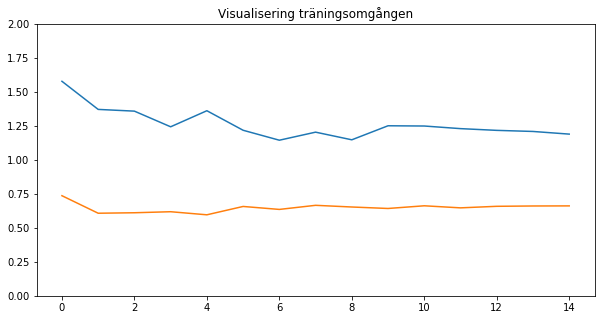

In [116]:
plt.figure(figsize=(10,5))
plt.title("Visualisering träningsomgången")
plt.plot(losses, label = "Loss")
plt.plot(accuracy, label = "Andel korrekta")
plt.ylim(0,2)
plt.show()

## Utvärdering

In [ ]:
# Valideringsmängden:
model.eval()

valid_correct_pred_per_epoch = 0
valid_accuracy = []
valid_losses = []

no_valid_images = len(valid_loader.dataset) # = 998
with torch.no_grad():
    # Antal iterationer = 998 / 16 = 63 st.
    for X_valid, y_valid in valid_dl:

        y_valid_pred = model.forward(X_valid)
        
        valid_predicted = torch.max(y_valid_pred.data, 1)[1]
        valid_is_correct = (valid_predicted == y_valid).sum()
        valid_correct_pred_per_epoch += valid_is_correct
        
        valid_loss = criterion(y_valid_pred, y_valid)
        valid_losses.append(valid_loss.item())
            
        valid_epoch_accuracy = valid_correct_pred_per_epoch.item() / no_valid_images
        valid_accuracy.append(valid_epoch_accuracy)
        
# epoch startar på 0, därav "+1" nedan:
print(f"Validering: accuracy = {valid_epoch_accuracy:4.4f} och loss är = {valid_loss:4.4f}")

In [ ]:
# Plotta accuracy och loss:

max_loss = np.max(train_losses).item()
max_accuracy = np.max(train_accuracy).item()
y_max = 1.1*max(max_loss, max_accuracy)

plt.plot(range(epochs), train_accuracy)
plt.plot(range(epochs), train_losses)
plt.title("Accuracy and loss per epoch on the train set")
plt.legend(['Accuracy', 'Loss'], loc='lower left')
plt.yticks(np.arange(0, y_max, step = 0.2))
plt.ylim(0, y_max)
plt.show()

In [ ]:
max_loss = np.max(valid_losses).item()
max_accuracy = np.max(valid_accuracy).item()
y_max = 1.1*max(max_loss, max_accuracy)

plt.plot(range(len(valid_losses)), valid_accuracy)
plt.plot(range(len(valid_losses)), valid_losses)
plt.title("Accuracy and loss on the validation set")
plt.legend(['Accuracy', 'Loss'], loc='upper left')
plt.yticks(np.arange(0, y_max, step = 0.2))
plt.ylim(0, y_max)
plt.show()

In [ ]:
def visualize_model(model, num_images=6):
    was_training = model.training
    model.eval()
    images_so_far = 0
    fig = plt.figure()

    with torch.no_grad():
        for i, (inputs, labels) in enumerate(test_loader):
            inputs = inputs.to(device)
            labels = labels.to(device)

            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)

            for j in range(inputs.size()[0]):
                images_so_far += 1
                ax = plt.subplot(num_images//2, 2, images_so_far)
                ax.axis('off')
                ax.set_title('predicted: {}'.format(class_names[preds[j]]))
                imshow(inputs.cpu().data[j])

                if images_so_far == num_images:
                    model.train(mode = was_training)
                    return
        model.train(mode = was_training)

### Elaborate training loop:

In [ ]:
import time
start_time = time.time()

epochs = 16

no_training_images = len(dataset_trainloader.dataset)

train_losses = []
test_losses = []
train_correct = []
test_correct = []

for epoch in range(epochs):
    trn_corr = 0
    tst_corr = 0
    
    # Run the training batches
    for currentbatch, (X_train, y_train) in enumerate(train_dl):
        currentbatch += 1
        
        # Apply the model
        y_pred_train = model(X_train)  # we don't flatten X-train here
        loss = criterion(y_pred_train, y_train)
 
        # Tally the number of correct predictions
        predicted = torch.max(y_pred_train.data, 1)[1]
        batch_corr = (predicted == y_train).sum()
        trn_corr += batch_corr
        
        # Update parameters
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        # Print interim results
        if currentbatch % 100 == 0:
            print(f'epoch: {epoch:2}  batch: {currentbatch:4} [{batchsz*currentbatch:4}/{no_training_images}]\
            loss: {loss.item():5.4f}\
            accuracy: {trn_corr.item()*100/(batchsz*currentbatch):5.1f} %')
        
    train_losses.append(loss)
    train_correct.append(trn_corr)

print(f'\nTraining took: {time.time() - start_time:.0f} seconds.') # print the time elapsed    

### 8. Evaluate the model on the test-set

In [ ]:
len(test_loader.dataset)

In [ ]:
model.eval()

no_test_images = len(test_loader.dataset)

with torch.no_grad():
    correct = 0
    # Antal iterationer = 2010 / 16 = 123 st.
    for X_test, y_test in test_dl:
        y_pred_test = model.forward(X_test)
        predicted = torch.max(input = y_pred_test, dim = 1)[1]
        correct += (predicted == y_test).sum()
        
print(f'Test accuracy: {correct.item()}/{no_test_images} = {correct.item()*100/(no_test_images):5.2f} %')